<a href="https://colab.research.google.com/github/hosngholami/RecommenderSystem/blob/main/RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install opendatasets
!pip install geopy
!pip install folium
!pip install -U pymoo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=6714d82d7744561e0233e8bfe0d14a83f4a2509cb4036db84e3148a8bab0a400
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors

pd.set_option("display.max_columns", 1000)
pd.set_option('display.max_rows', 1000)
np.set_printoptions(threshold=np.inf)

In [15]:
import random
locations = pd.read_csv('/content/drive/MyDrive/Shiraz/locations.csv')
locations["Id"] = [i for i in range(0, len(locations))]
locations["Stars"] = 0
locations["Price"] = 0
# locations["Price"] = [random.randint(10, 200) for i in range(len(locations))]

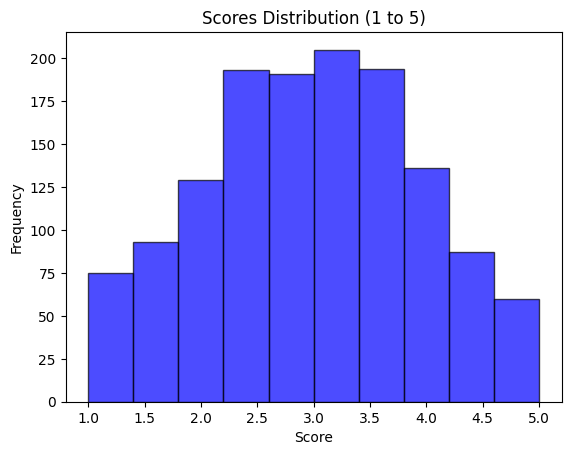

In [19]:
mean_score = 3  # میانگین امتیاز (در وسط بازه 1 تا 5)
std_dev = 1     # انحراف معیار امتیاز

# تعداد آیتم‌ها
num_items = len(locations)

# تولید امتیازات خام با توزیع نرمال
raw_scores = np.random.normal(mean_score, std_dev, num_items)
scores = np.clip(raw_scores, 1, 5)
data = pd.DataFrame({'Item': [f'Item_{i+1}' for i in range(num_items)], 'Score': scores})

# مرتب‌سازی بر اساس امتیاز و اختصاص رتبه
data = data.sort_values(by='Score', ascending=False).reset_index(drop=True)
data['Rank'] = data.index + 1

# رسم هیستوگرام امتیازات
plt.hist(scores, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Scores Distribution (1 to 5)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

locations["Stars"] = scores

In [6]:
def getLocation():
   location = locations[locations["type"] != "hotel"].sample(n=1)
   return location["Id"].values[0]

In [7]:
class GeneticAlgorithmConfig():
  totalLocationSize = 1
  hotelSize = 1
  numberLocationSize = len(locations[locations["type"] != "hotel"])
  timePlaceMappingSize = 2
  n_var = ((numberLocationSize * timePlaceMappingSize) +
         (hotelSize * timePlaceMappingSize) +
         (totalLocationSize))

In [8]:
def getSliceRoute(route):
  length = route[0] * GeneticAlgorithmConfig.timePlaceMappingSize
  startHead = GeneticAlgorithmConfig.hotelSize
  endHead = (GeneticAlgorithmConfig.hotelSize * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize

  startTail = length + endHead
  endTail  = length + endHead + GeneticAlgorithmConfig.timePlaceMappingSize
  interior = []
  if(route[0] != 0):
      interior = route[endHead:startTail]

  return (route[startHead:endHead], interior, route[startTail:endTail])

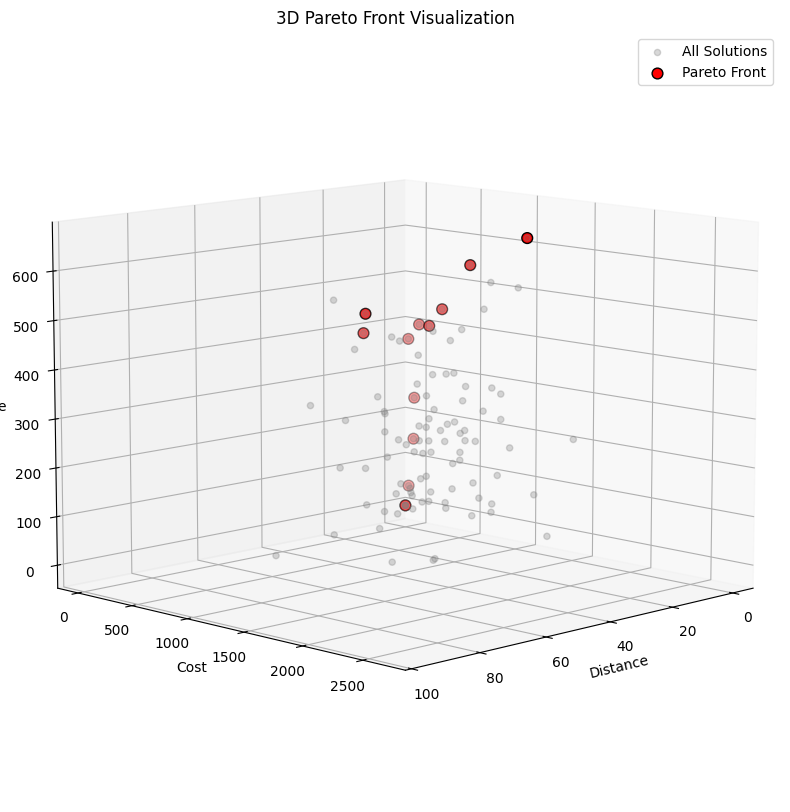

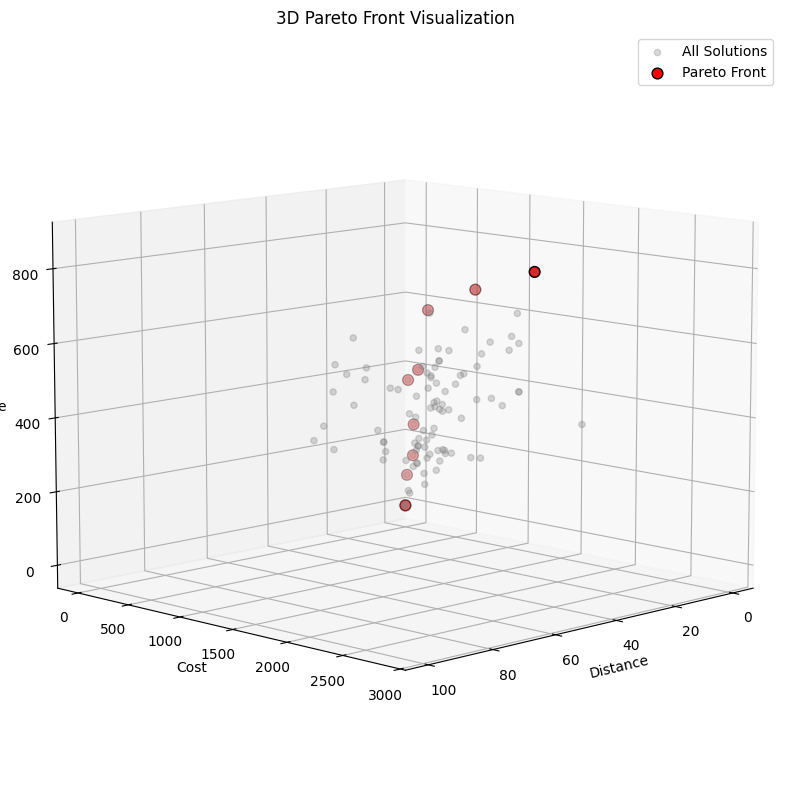

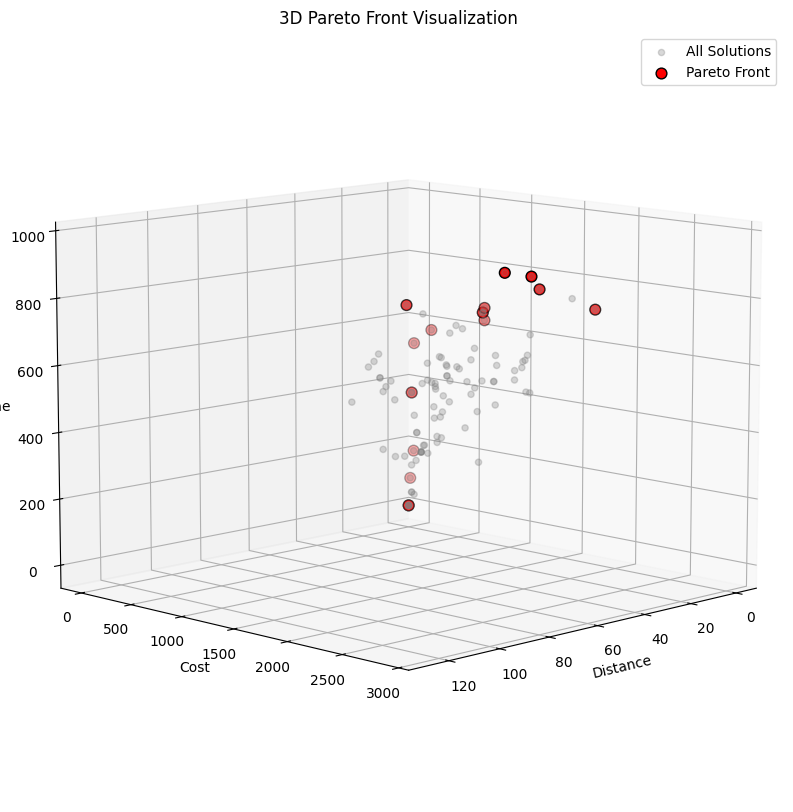

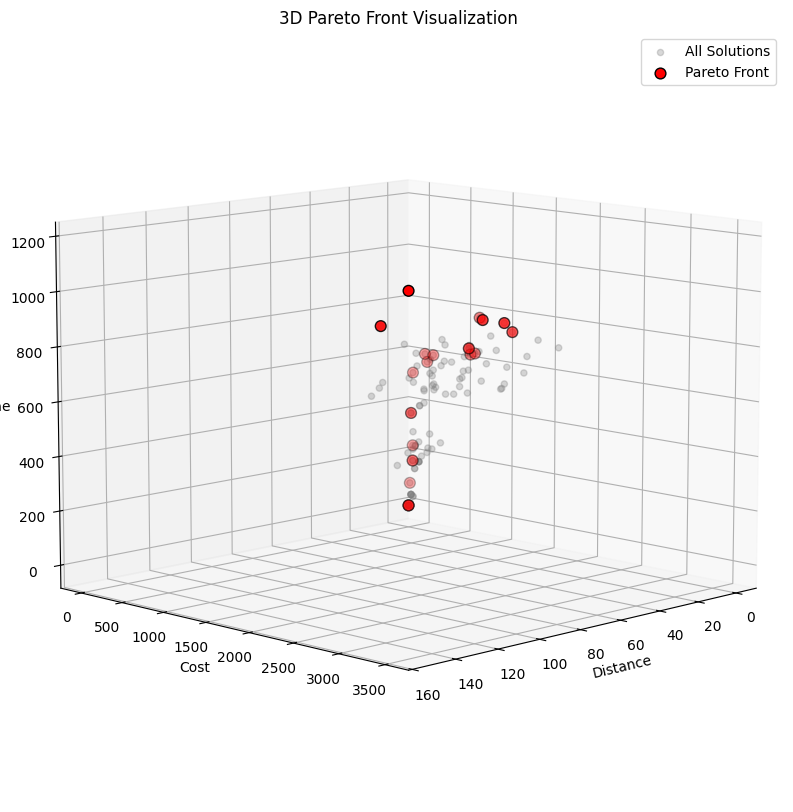

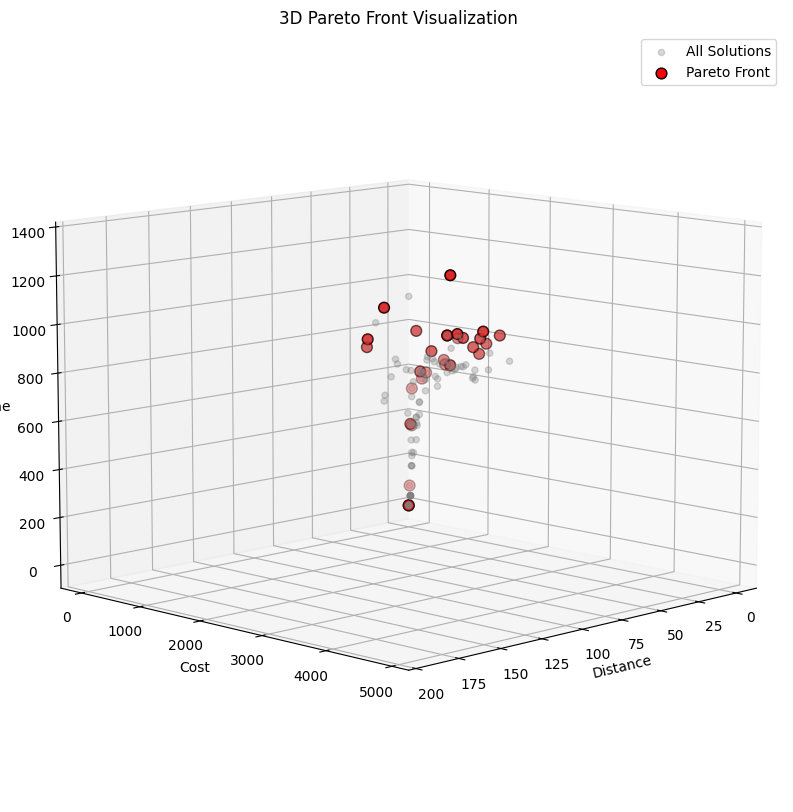

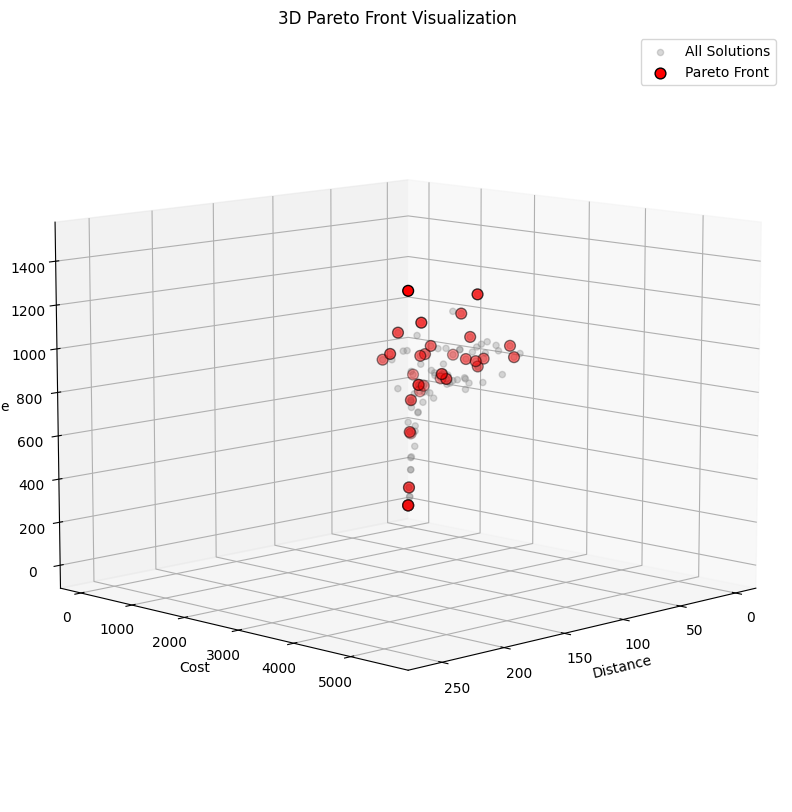

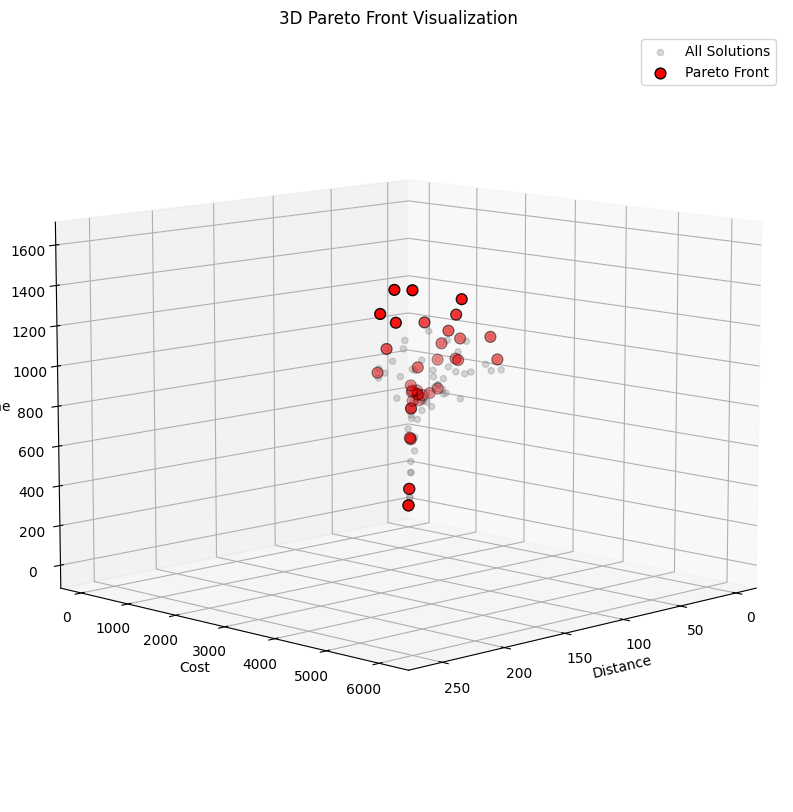

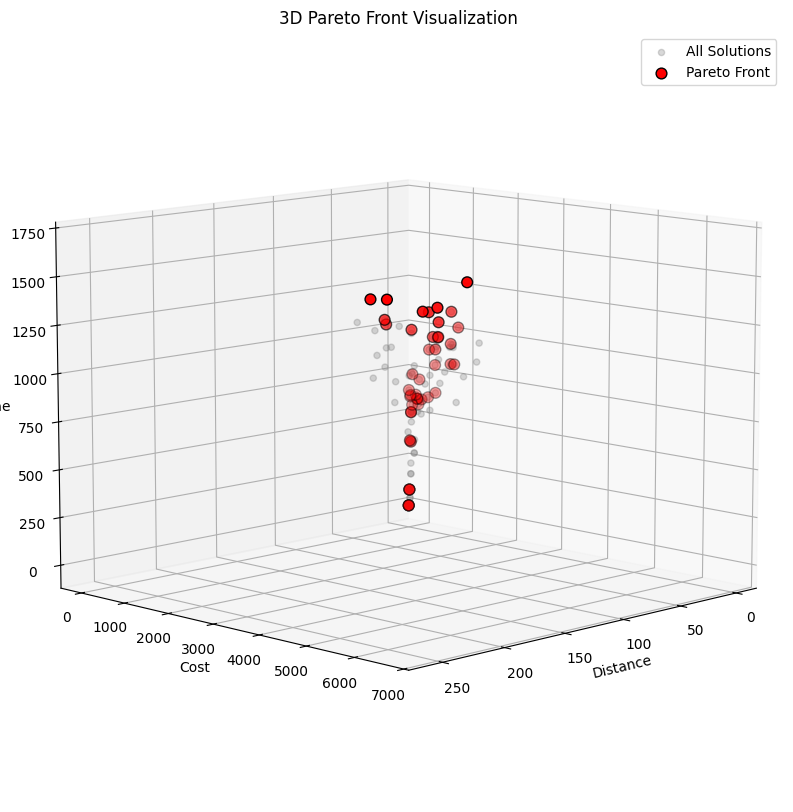

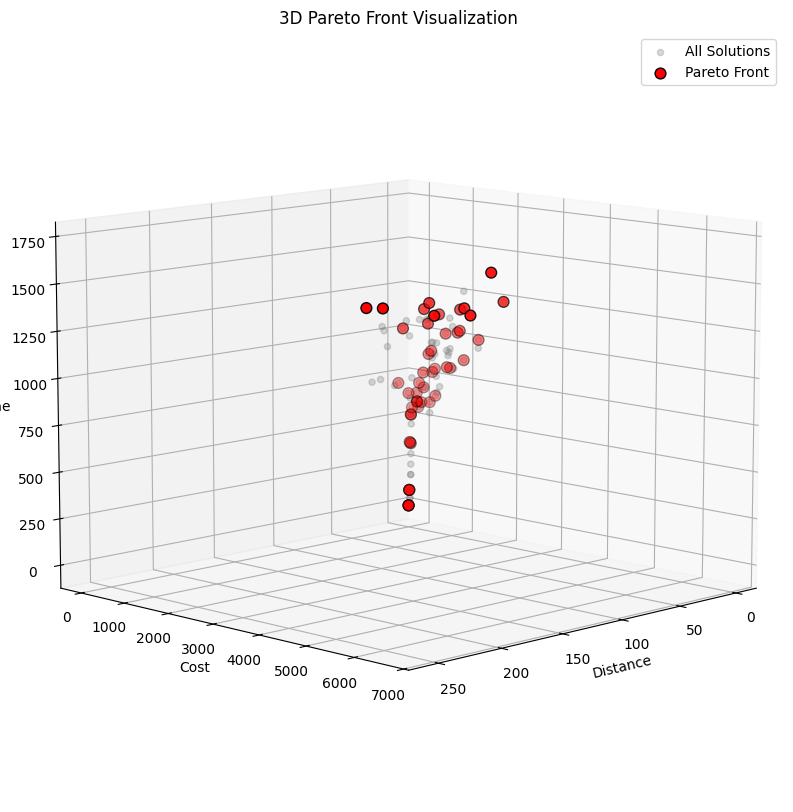

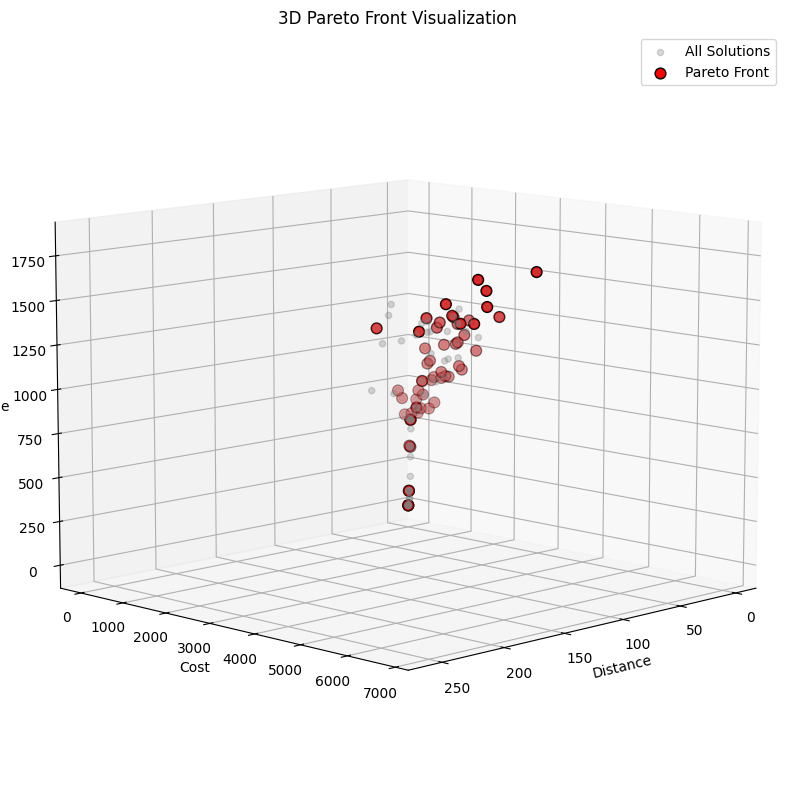

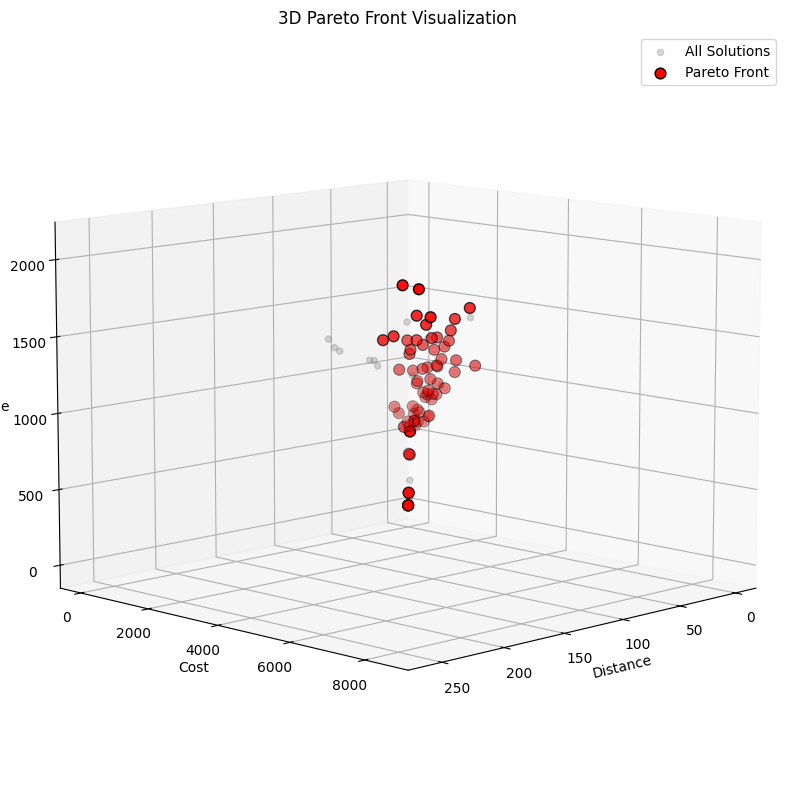

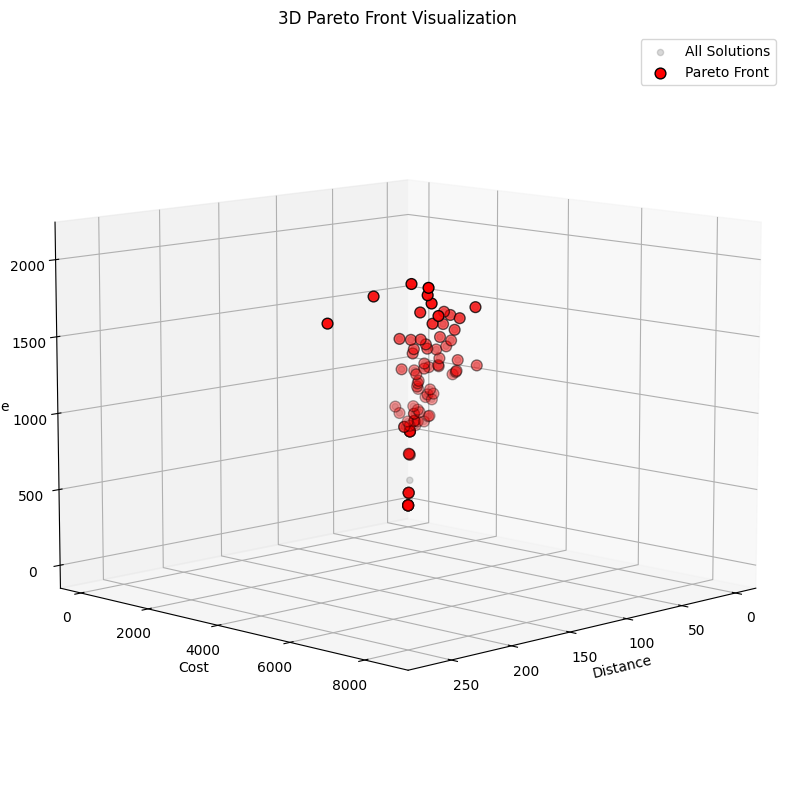

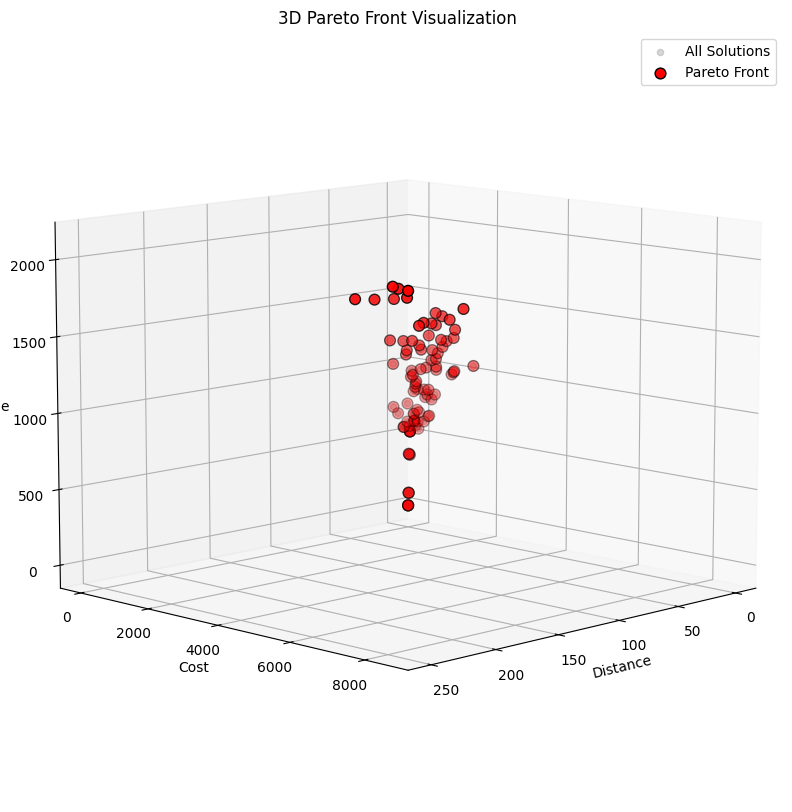

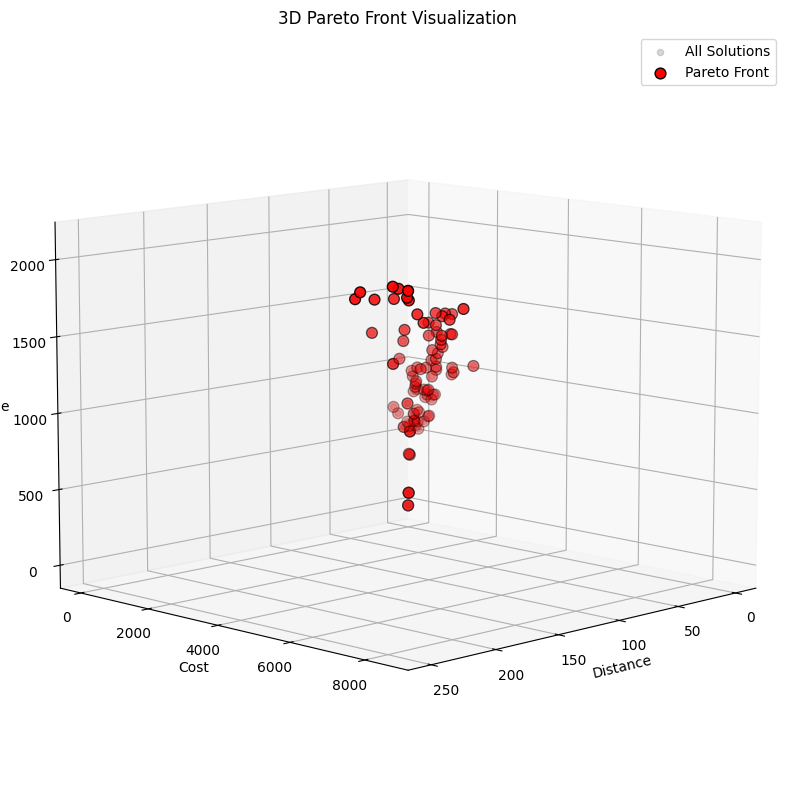

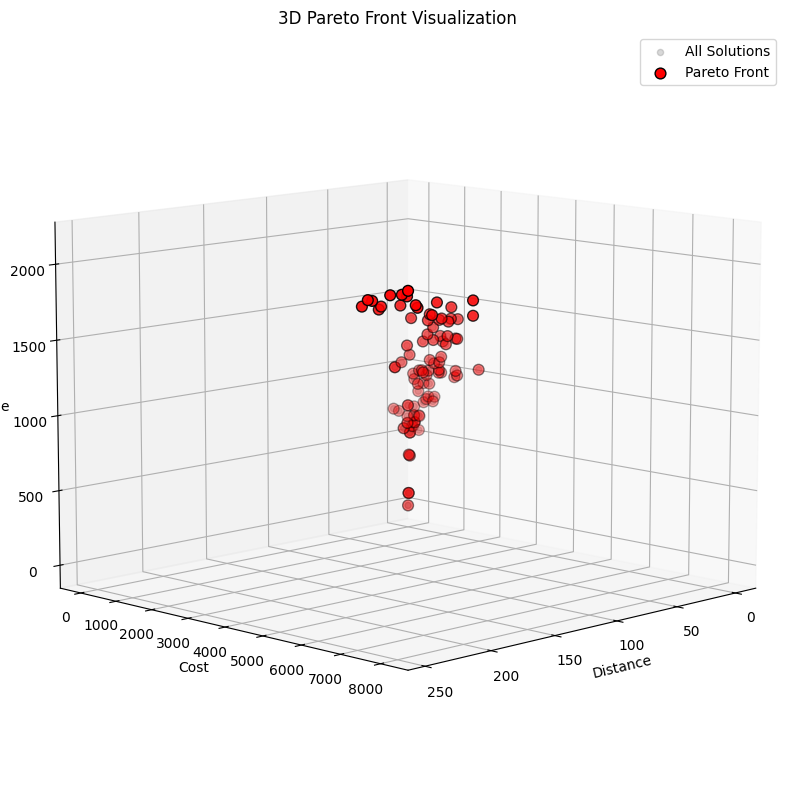

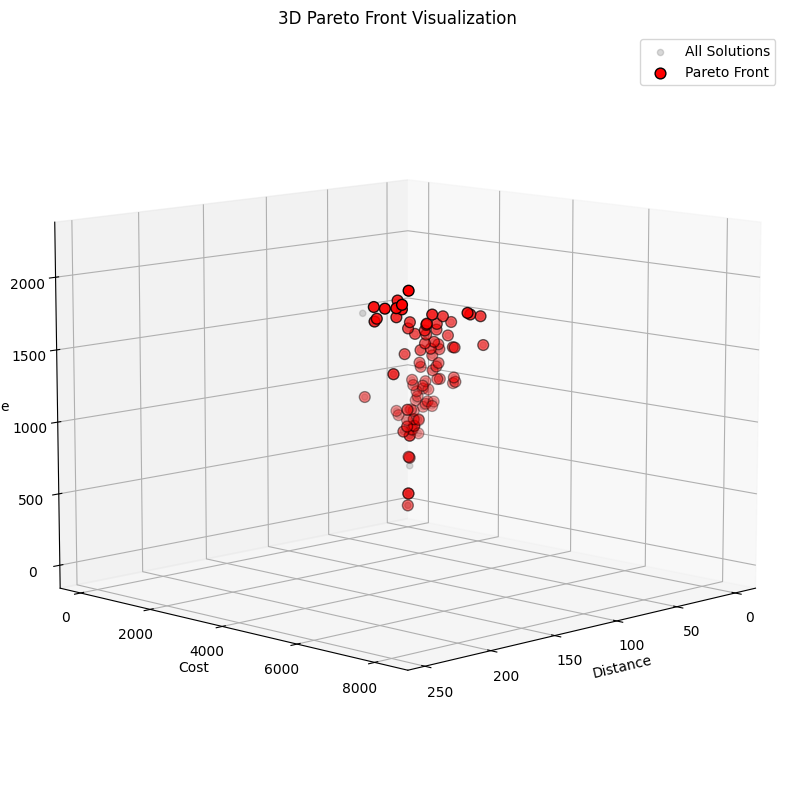

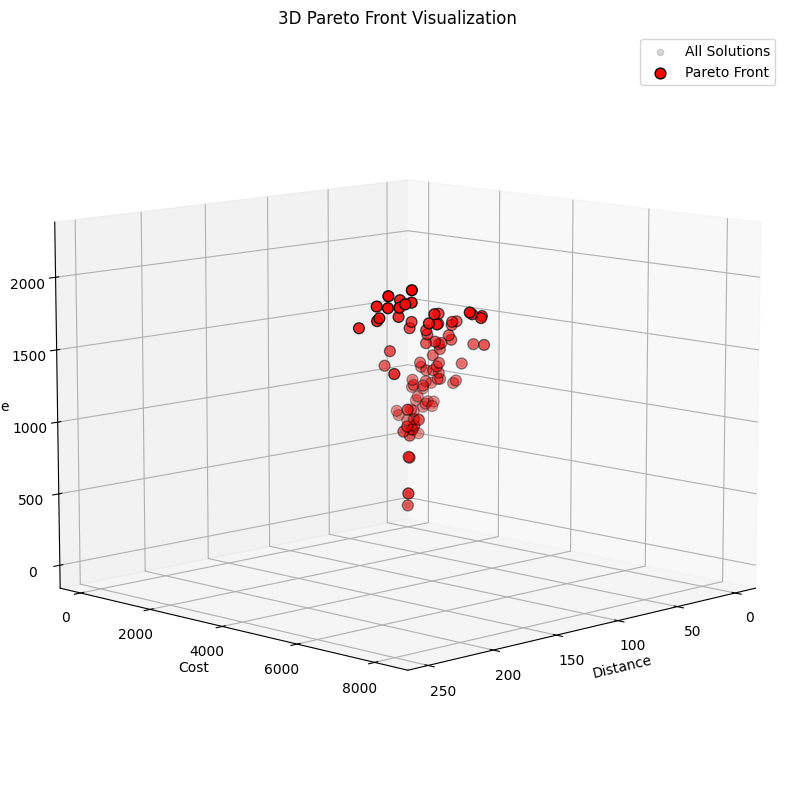

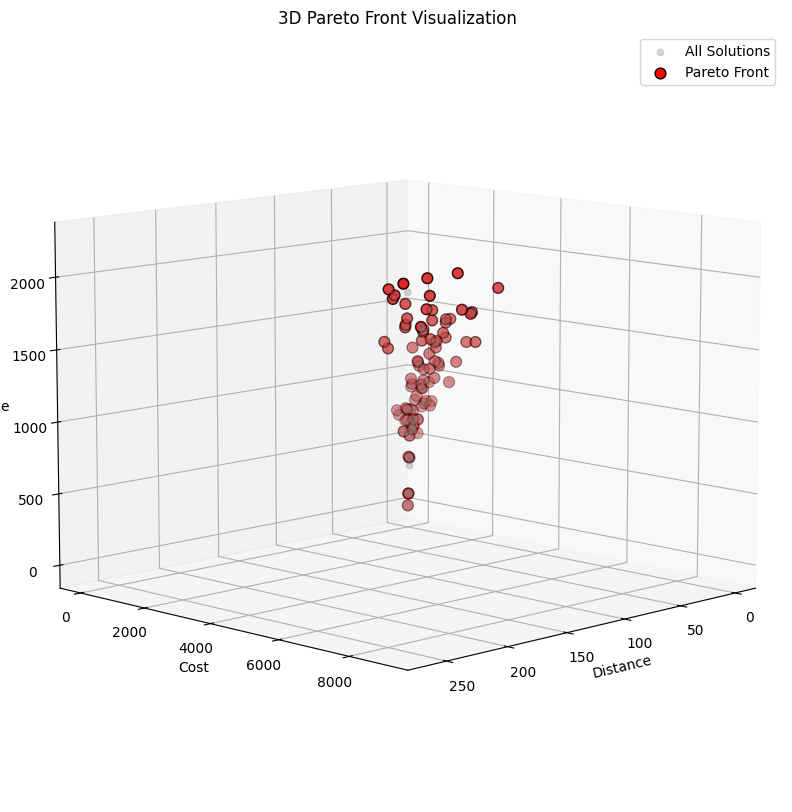

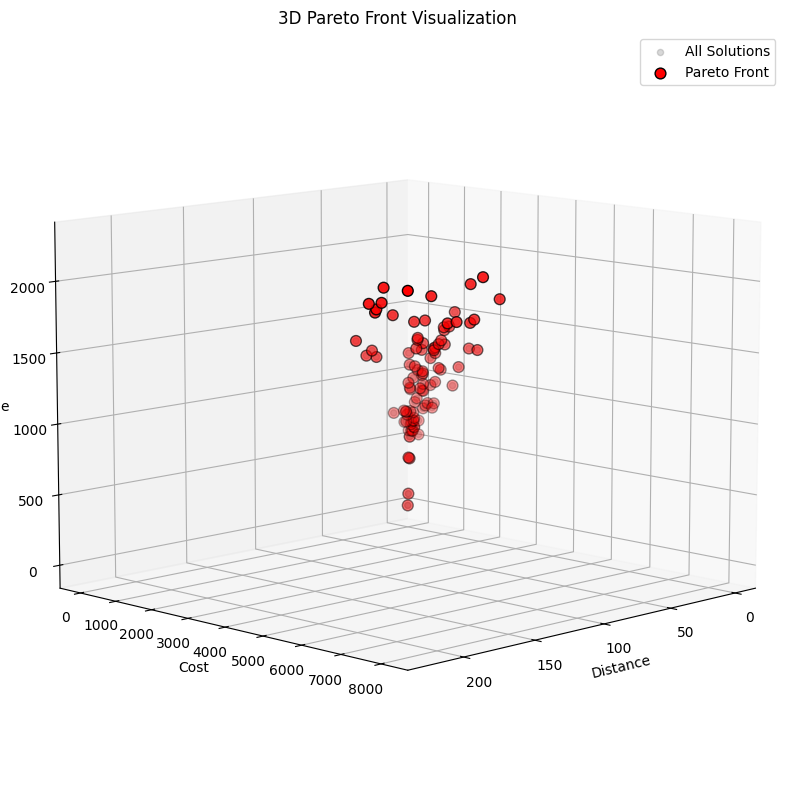

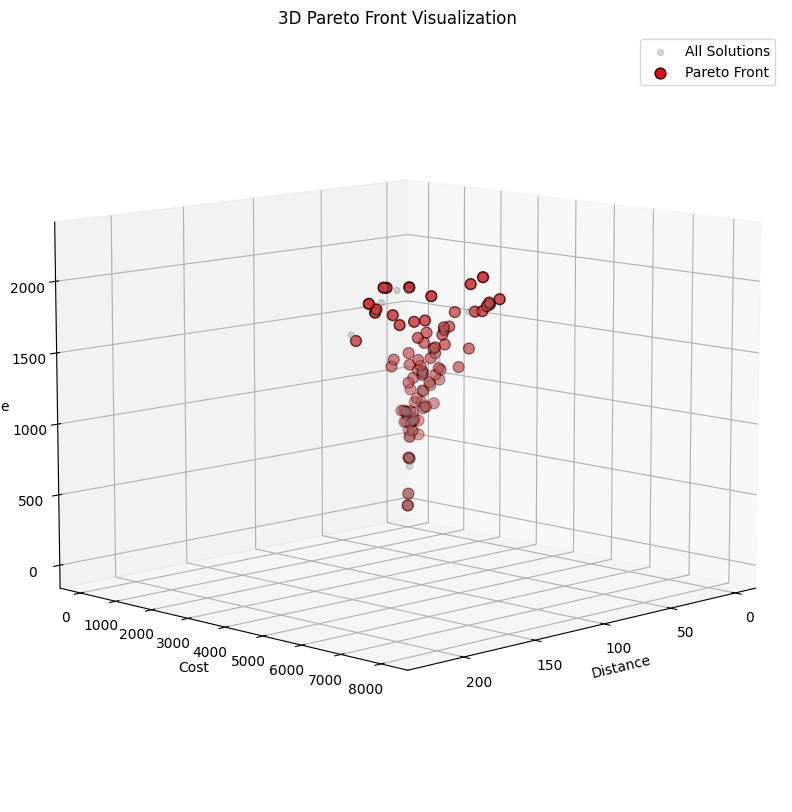

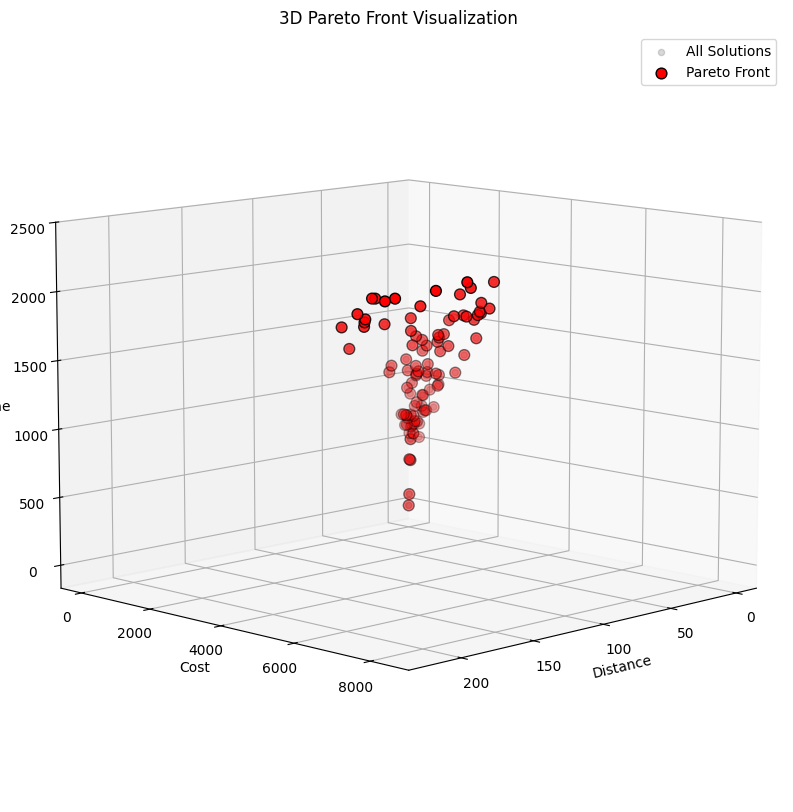

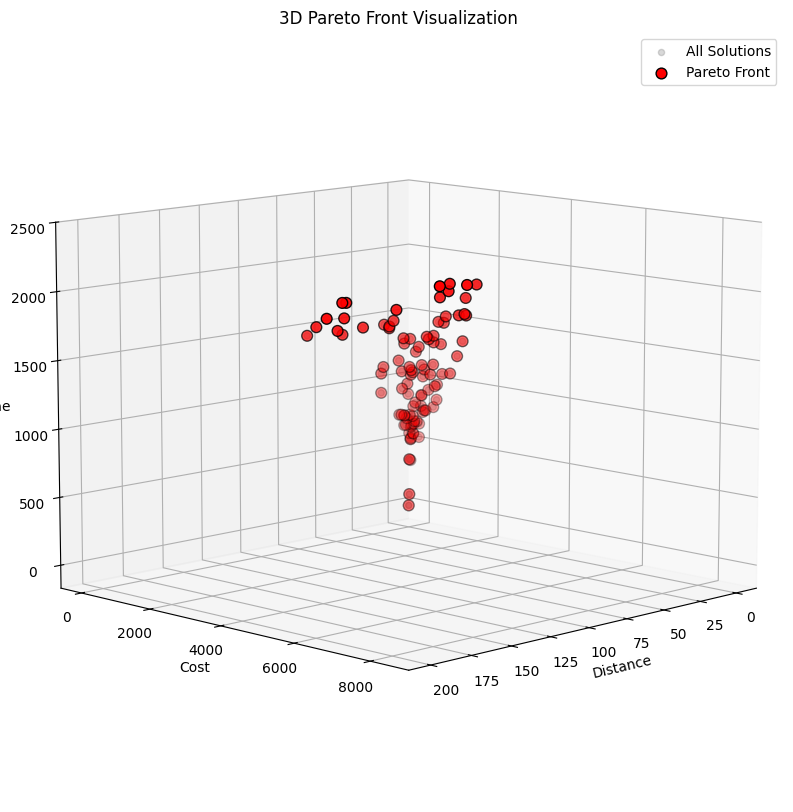

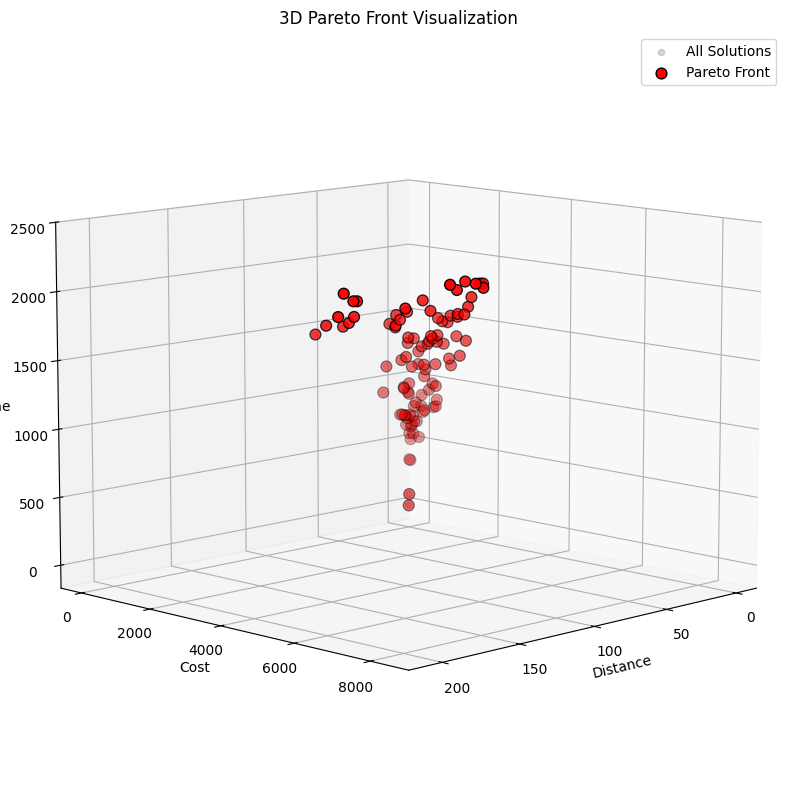

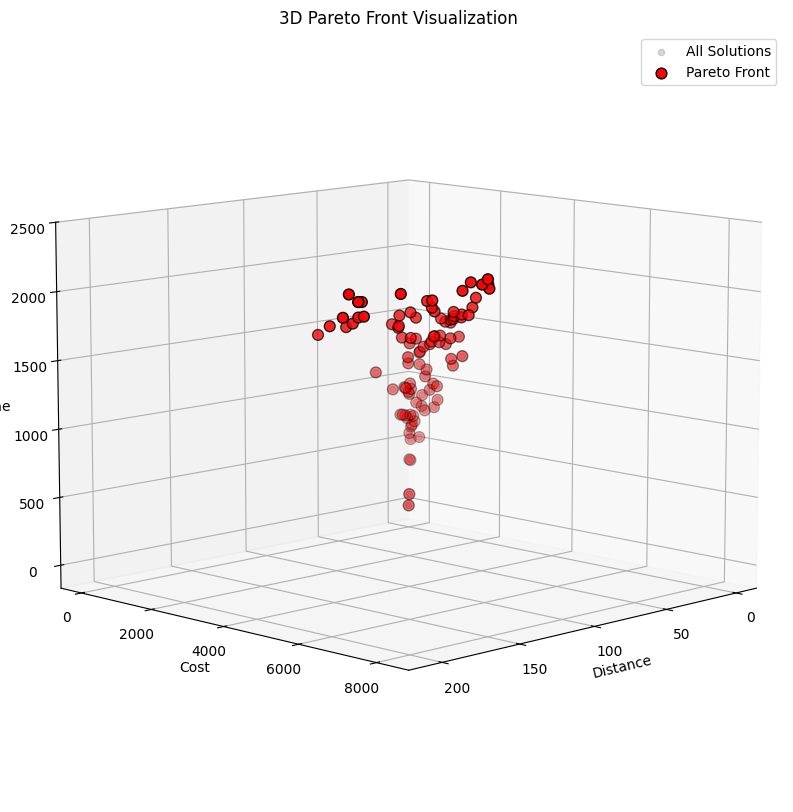

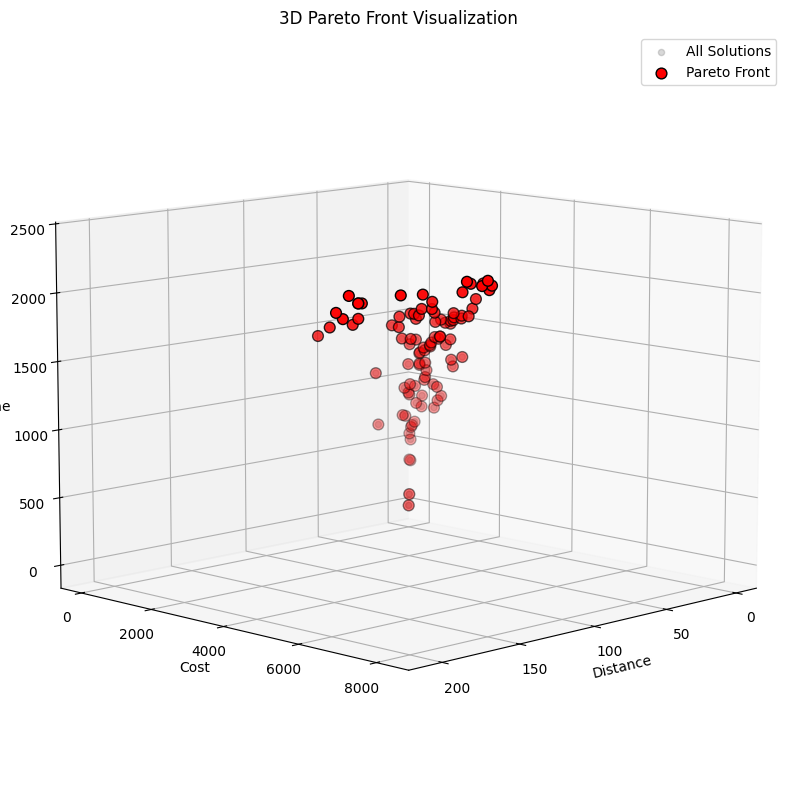

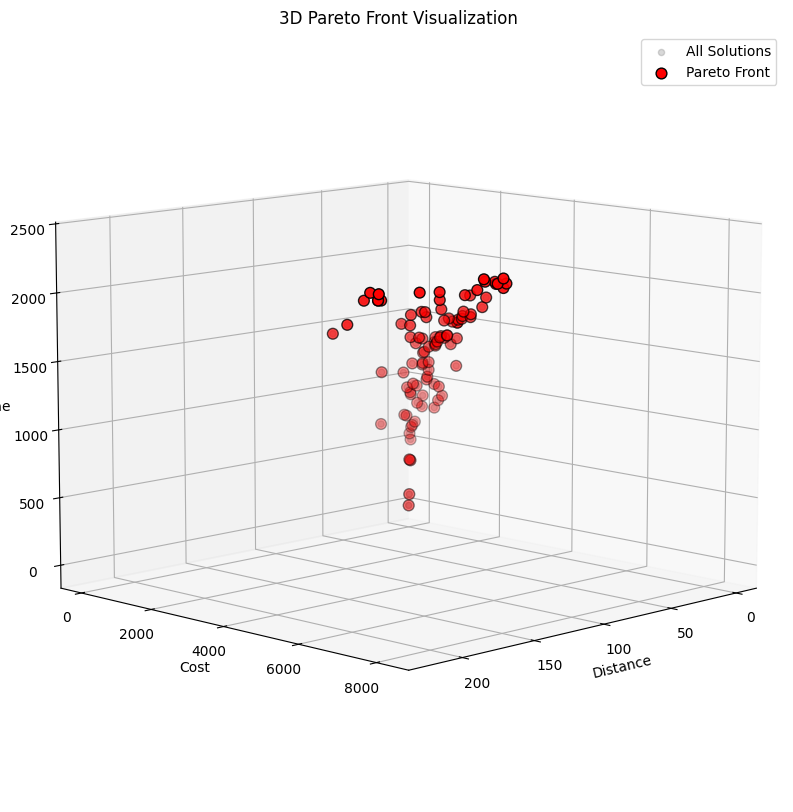

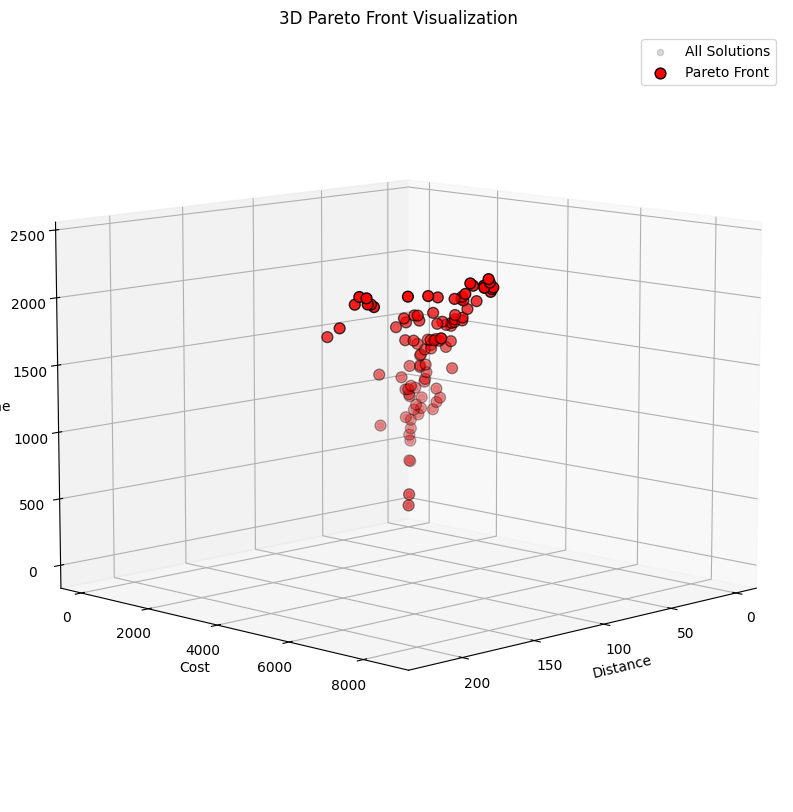

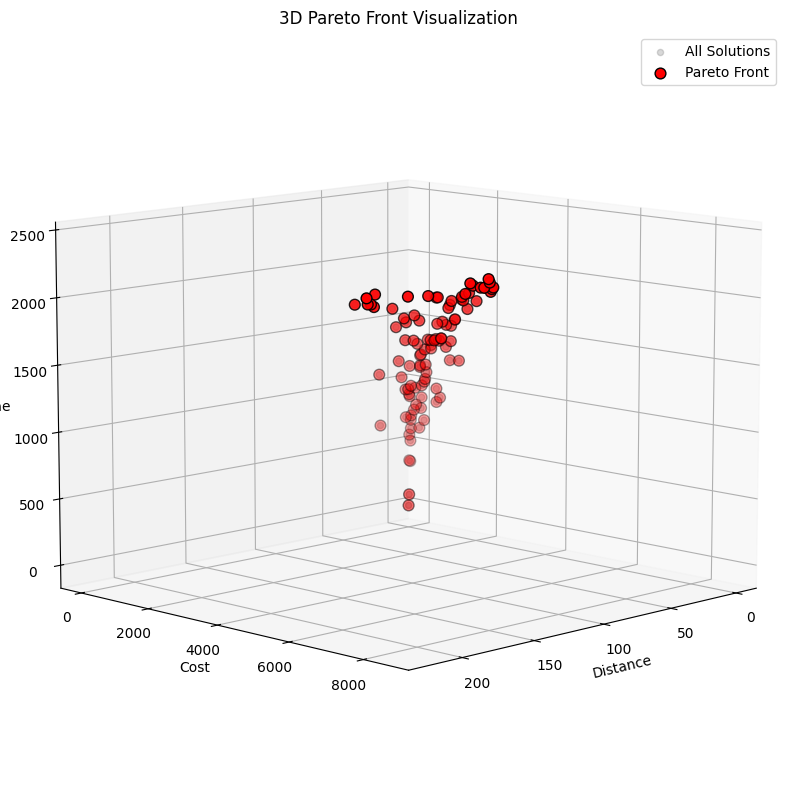

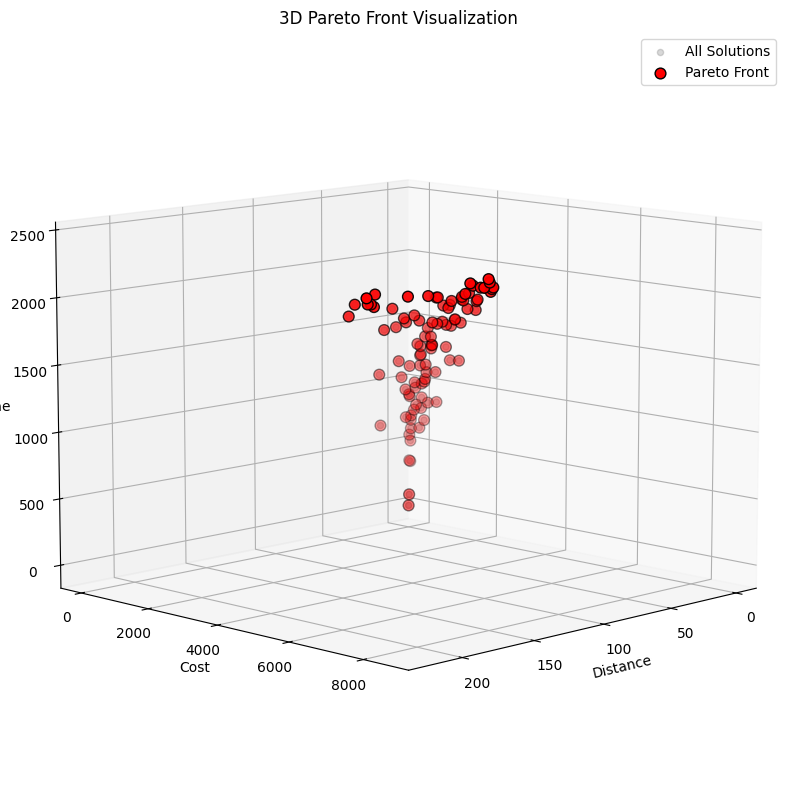

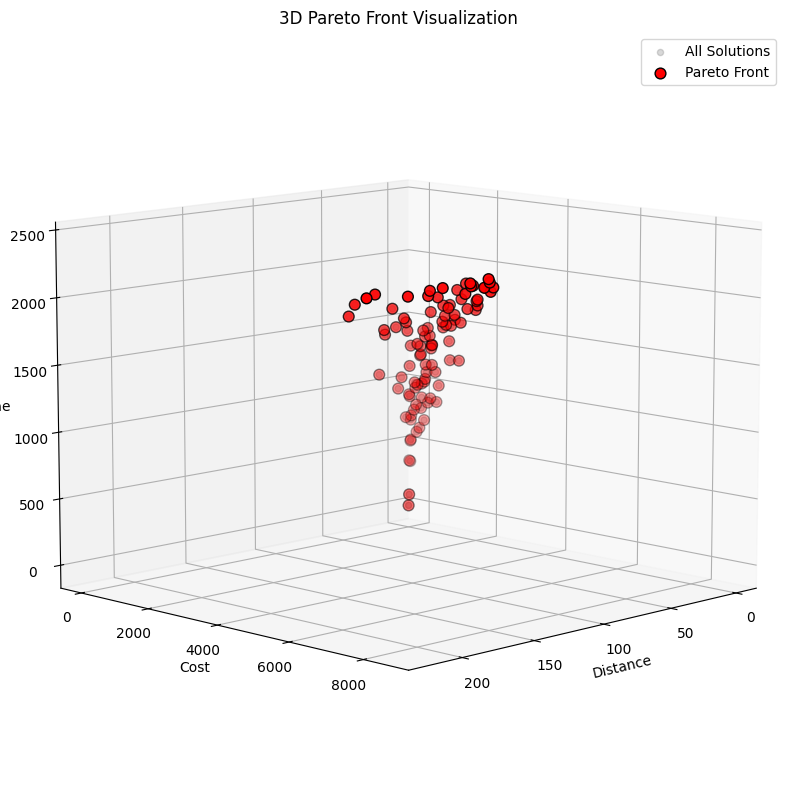

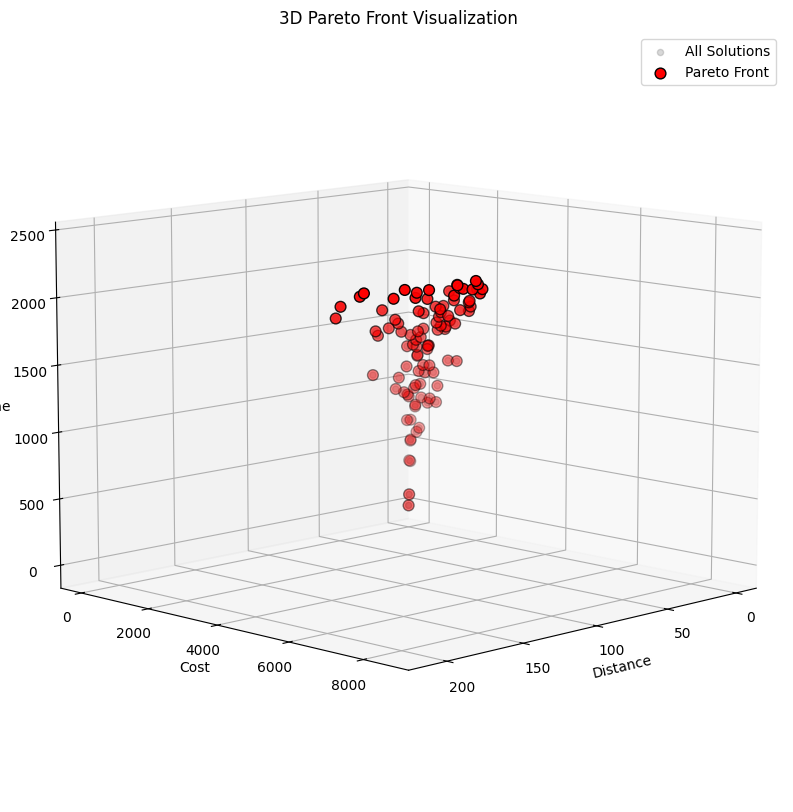

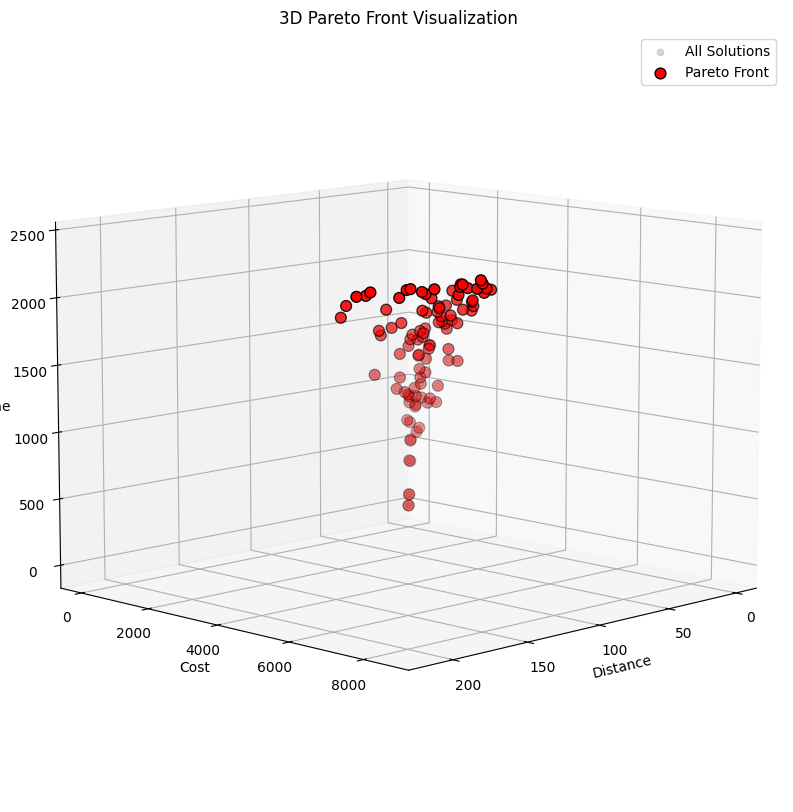

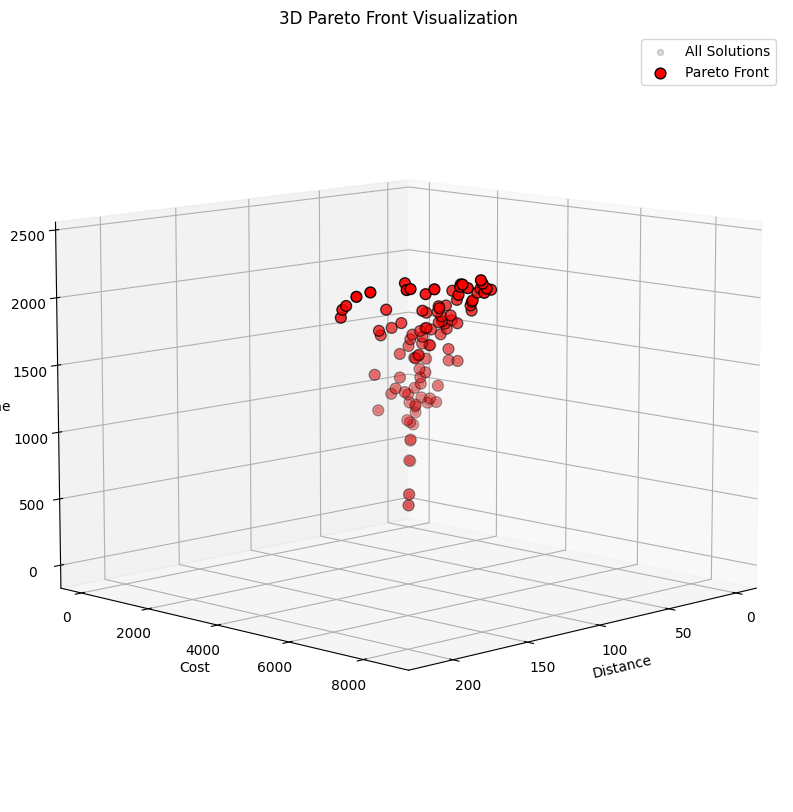

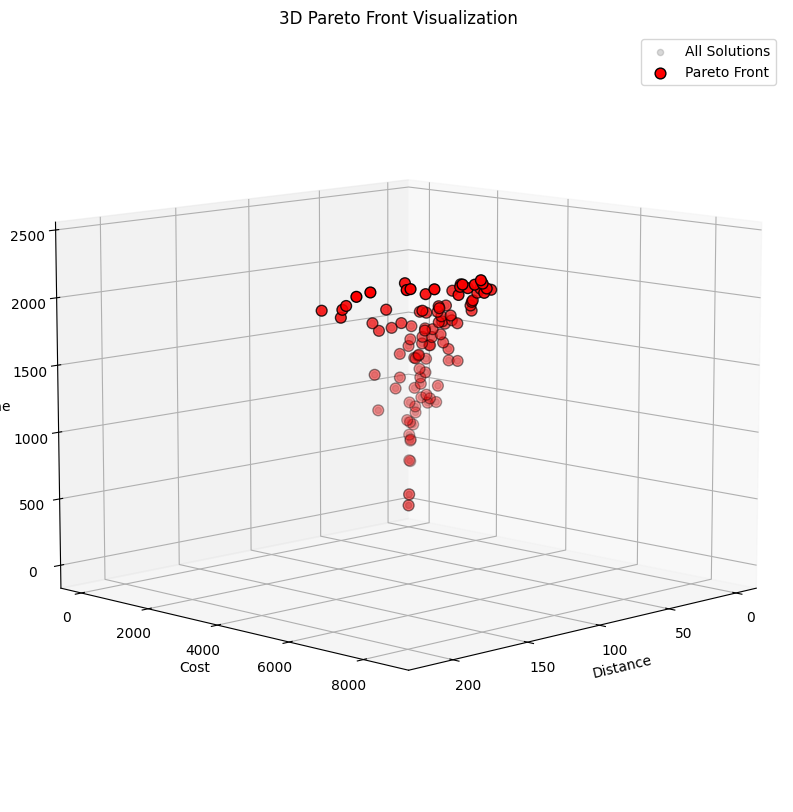

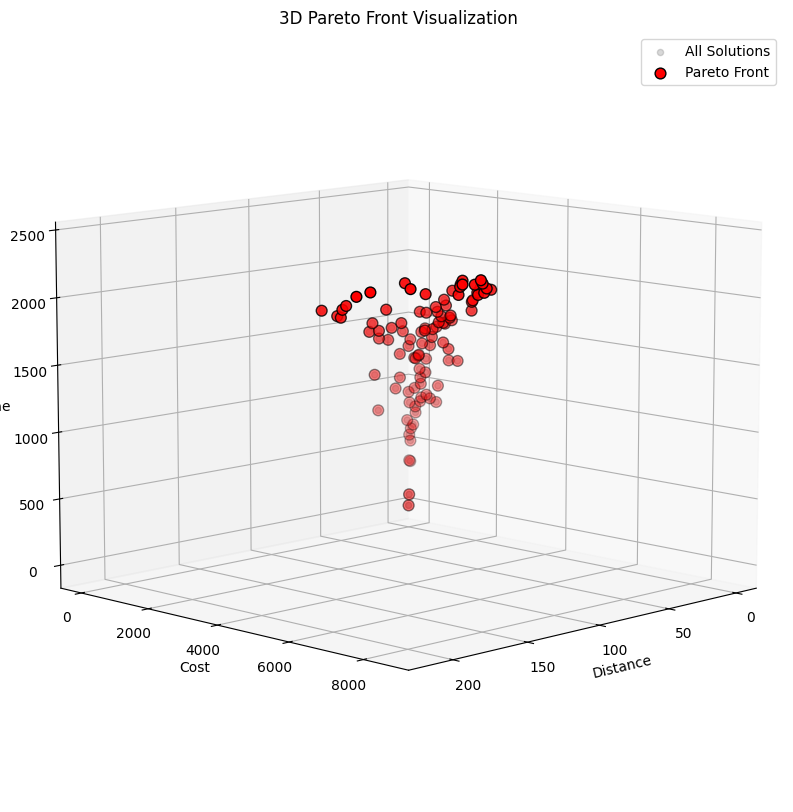

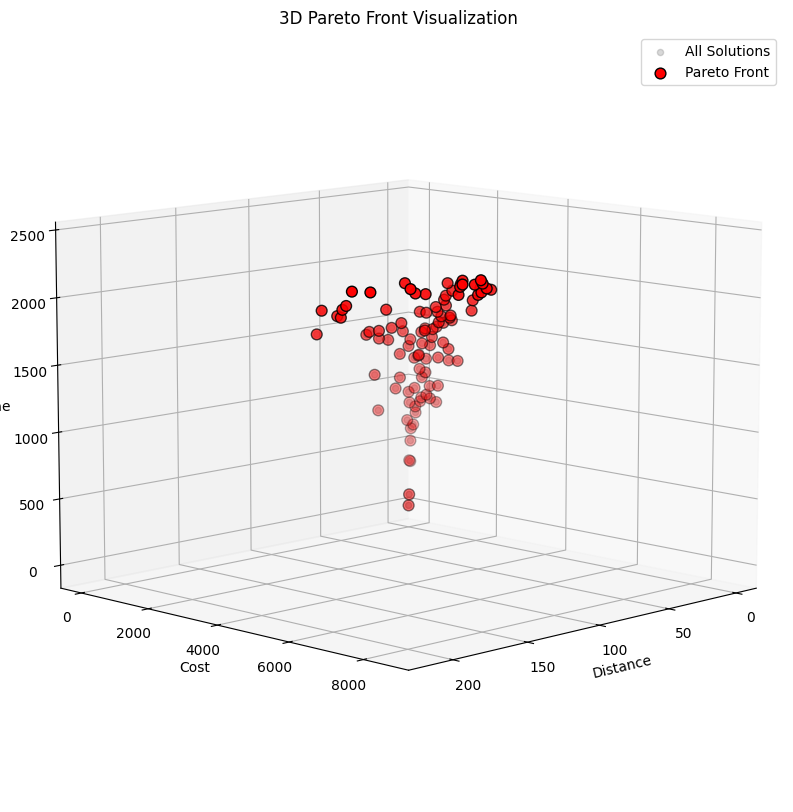

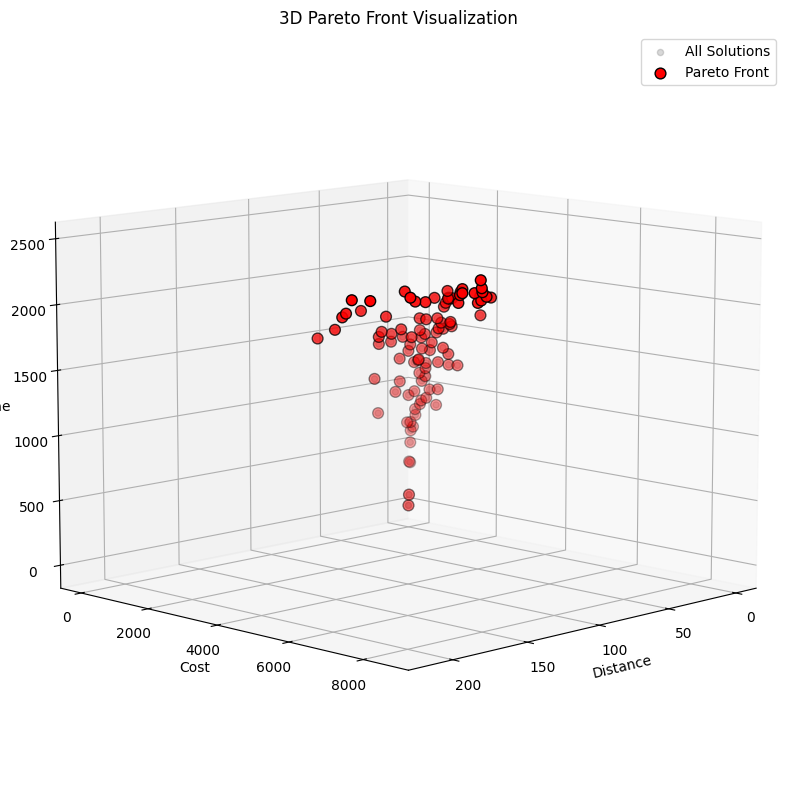

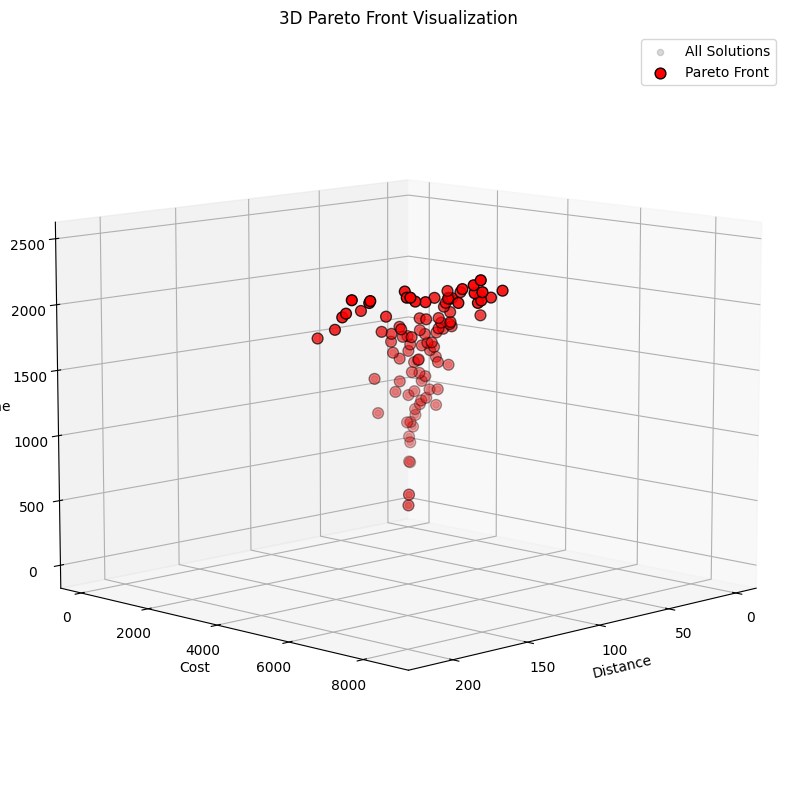

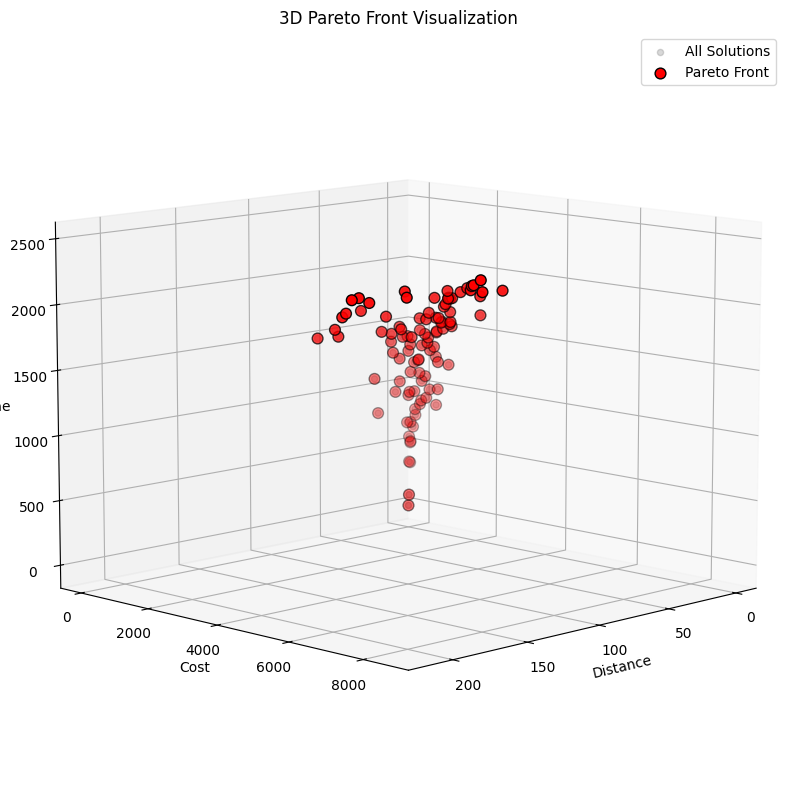

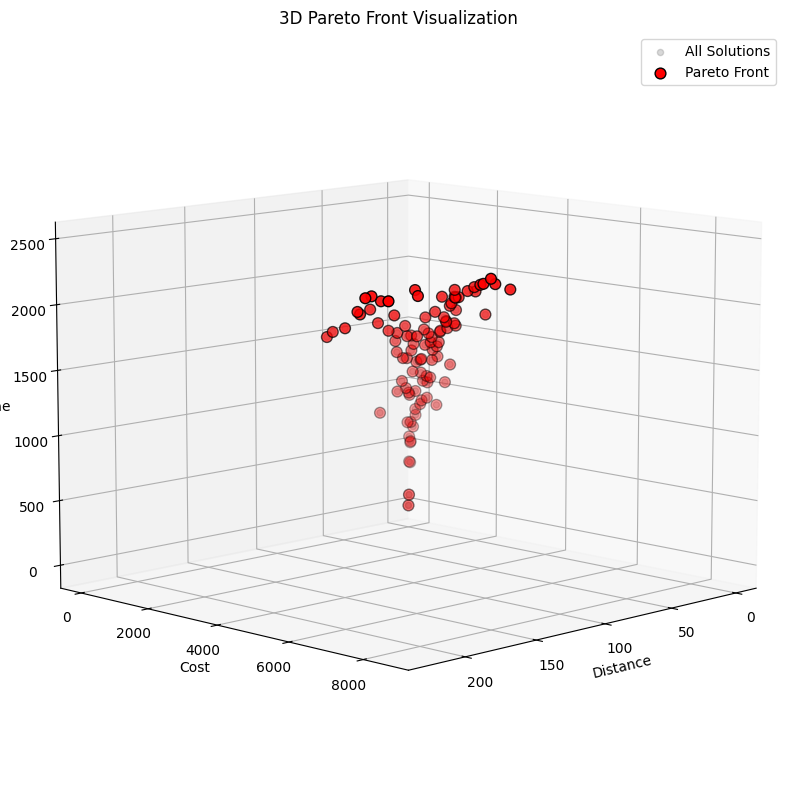

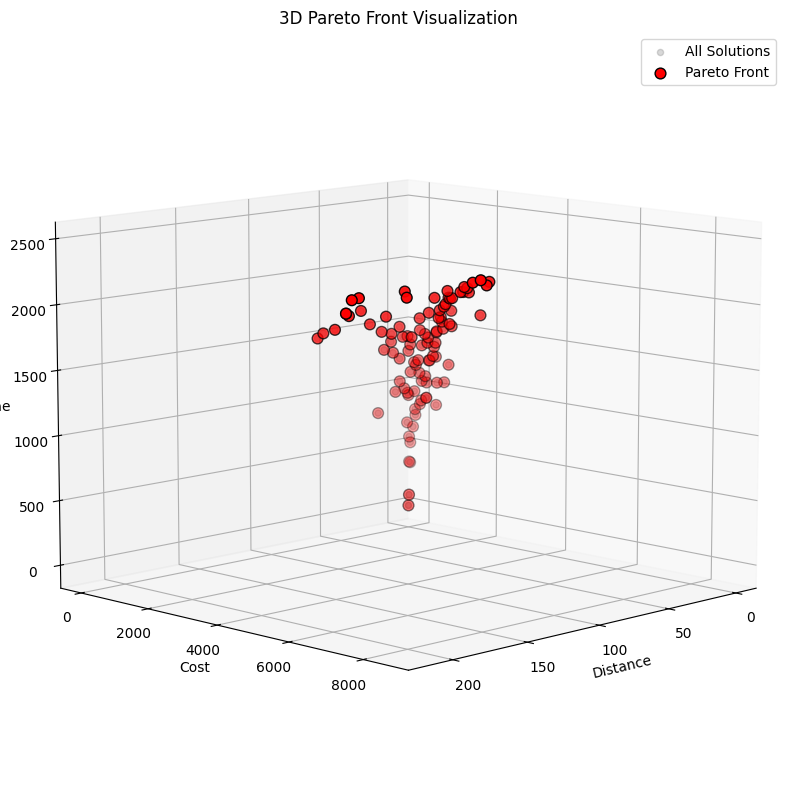

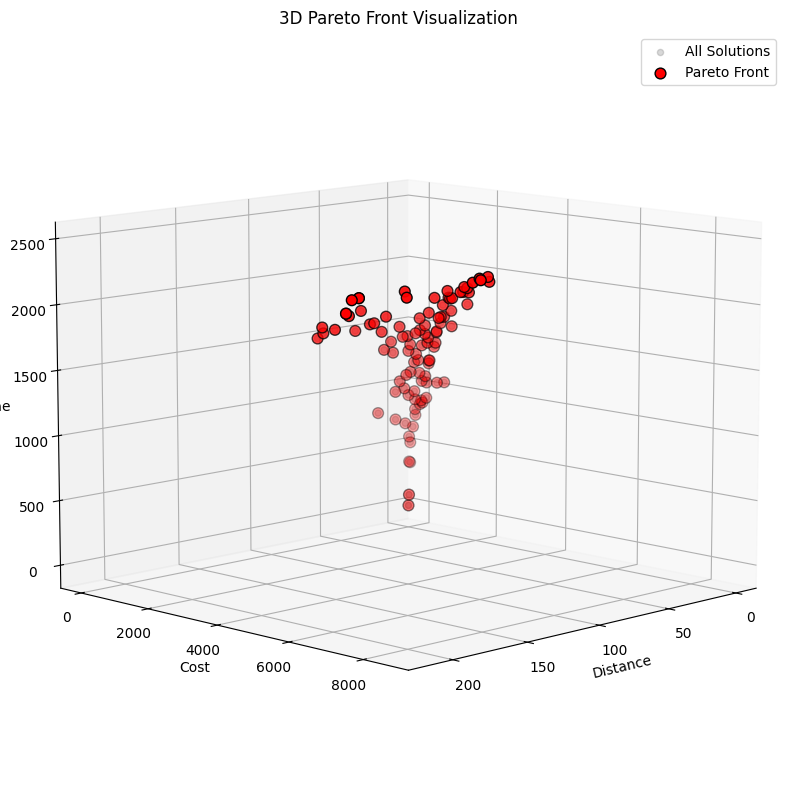

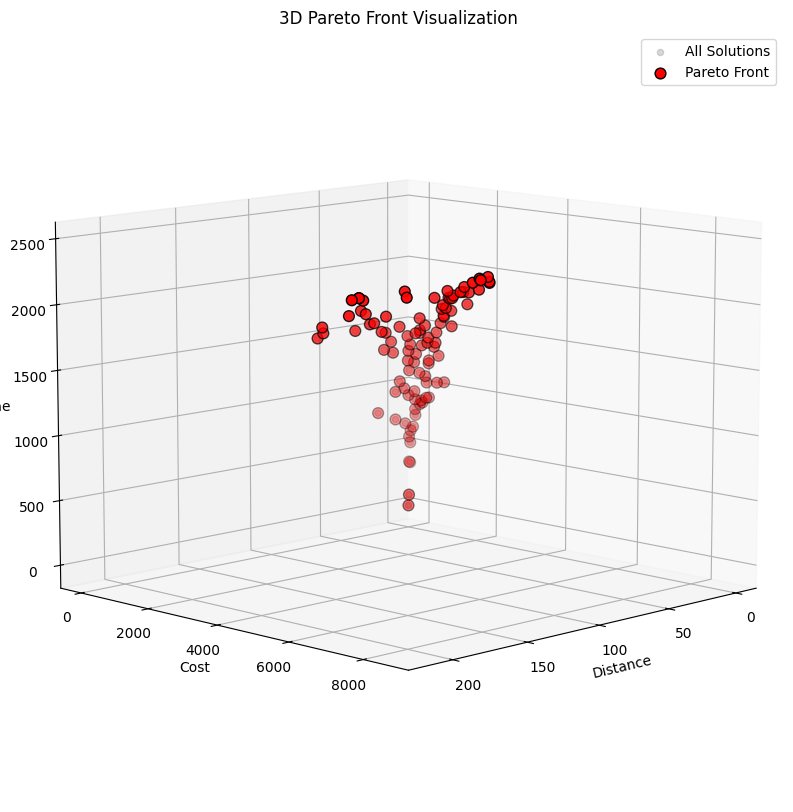

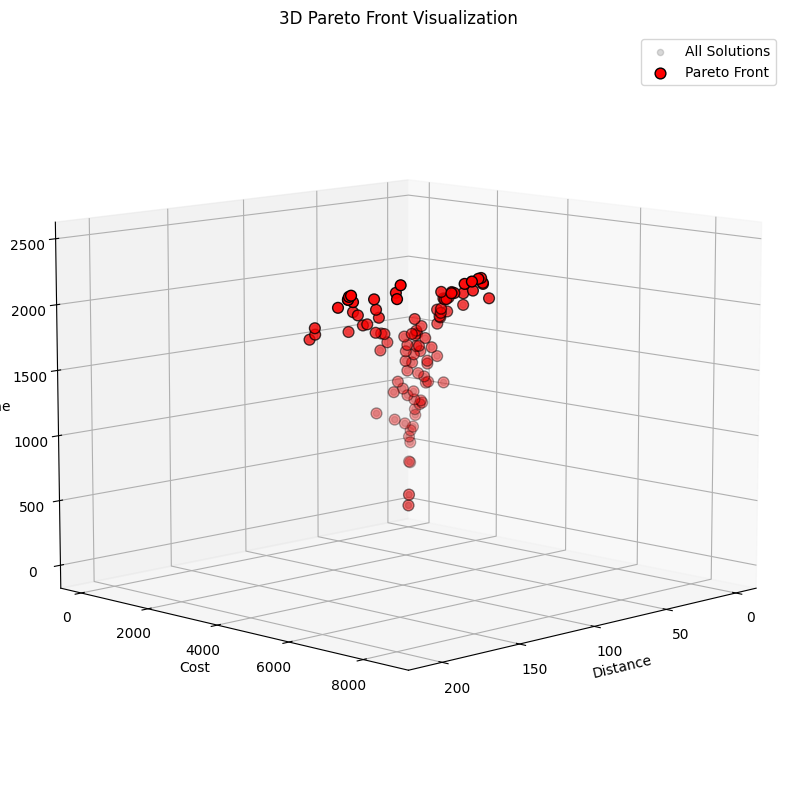

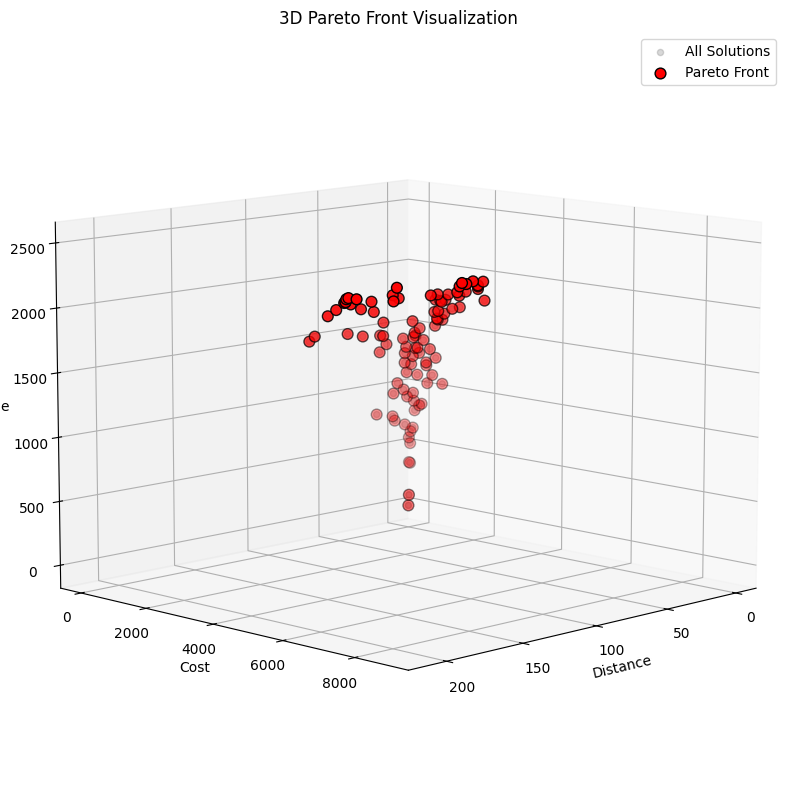

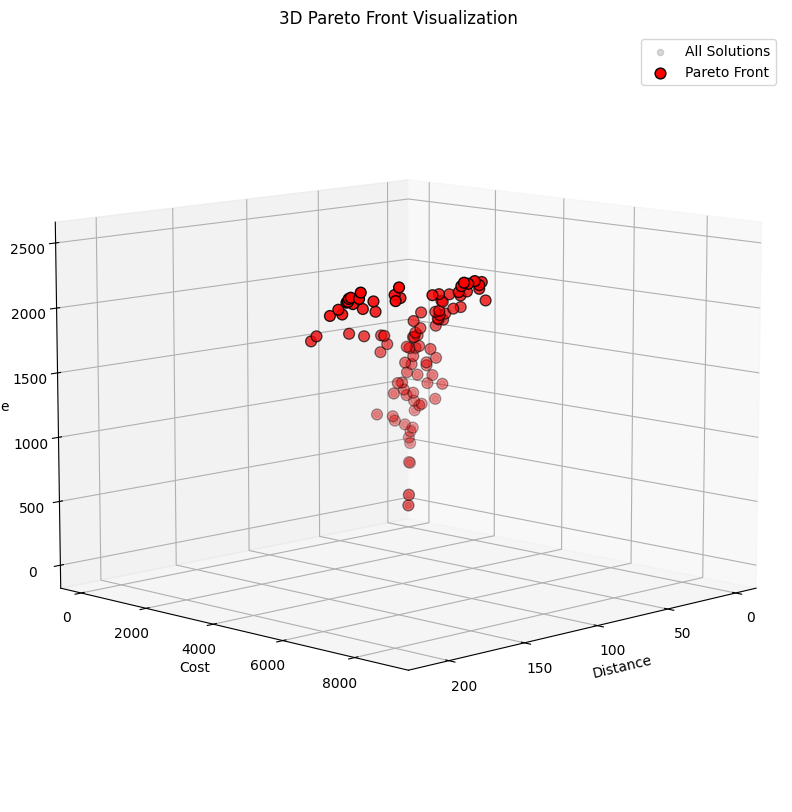

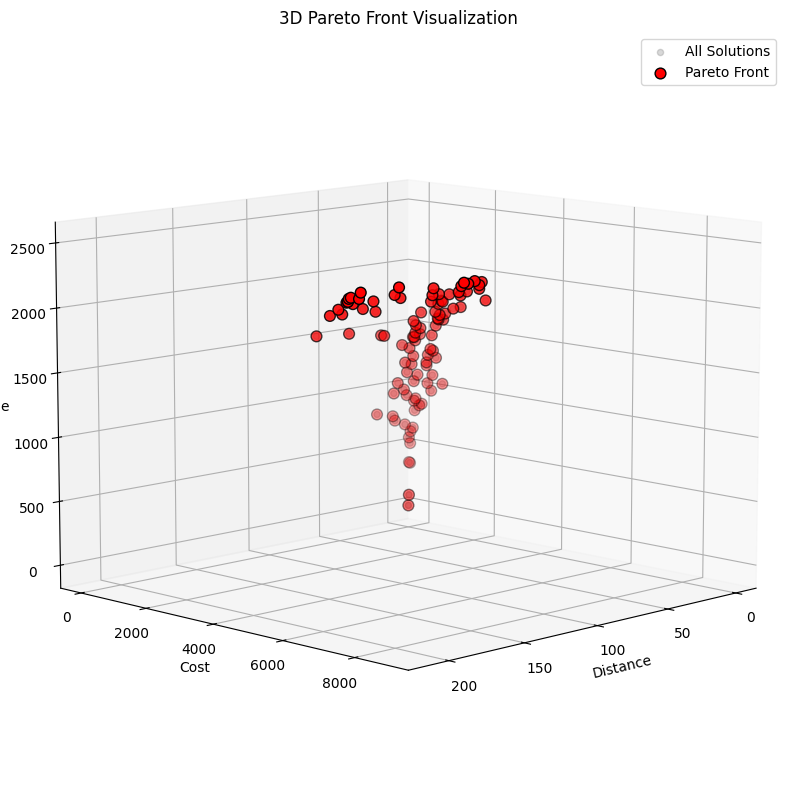

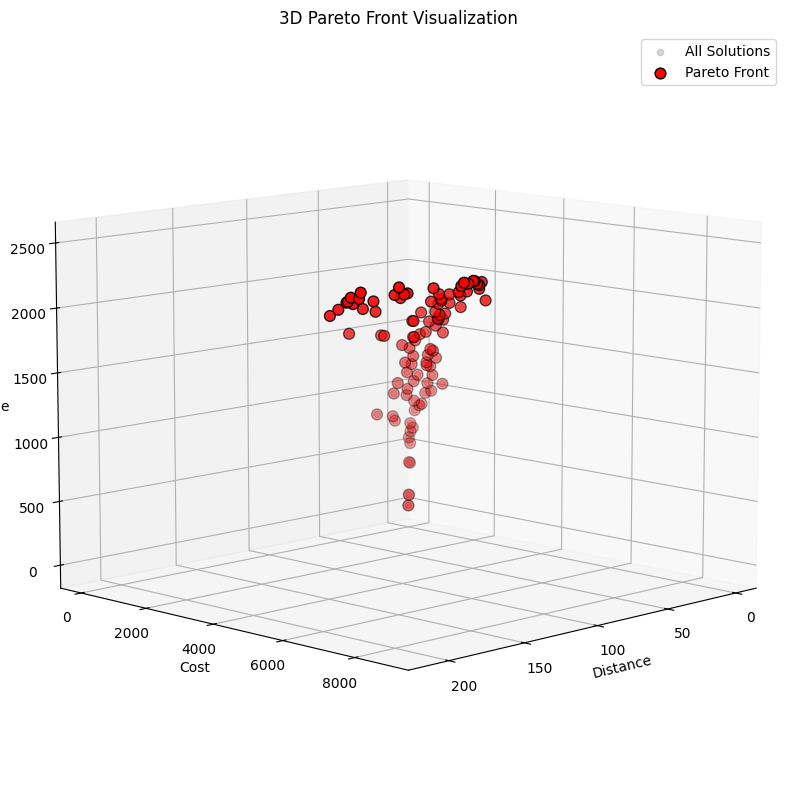

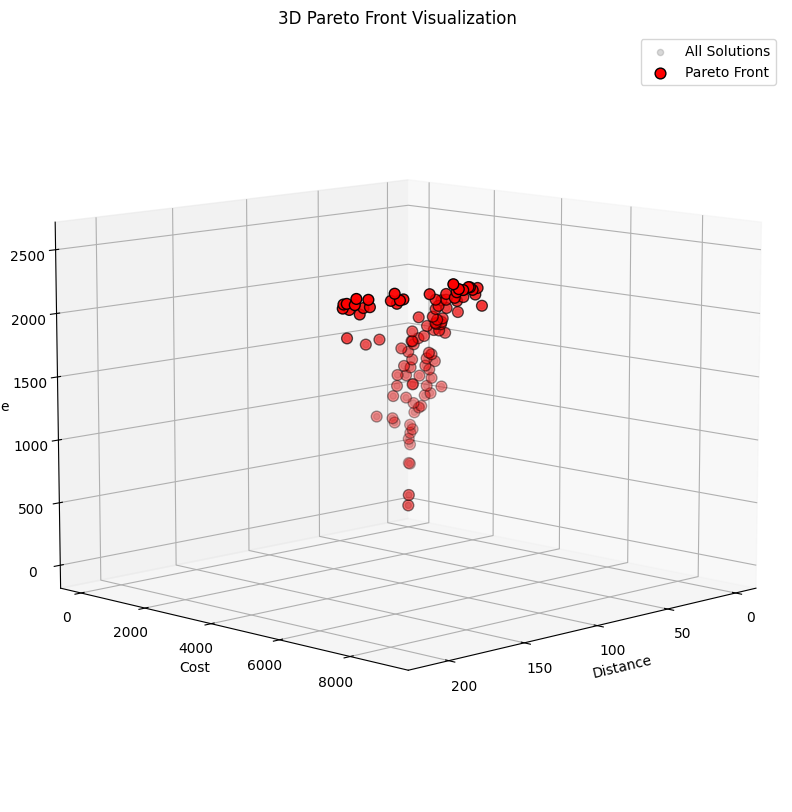

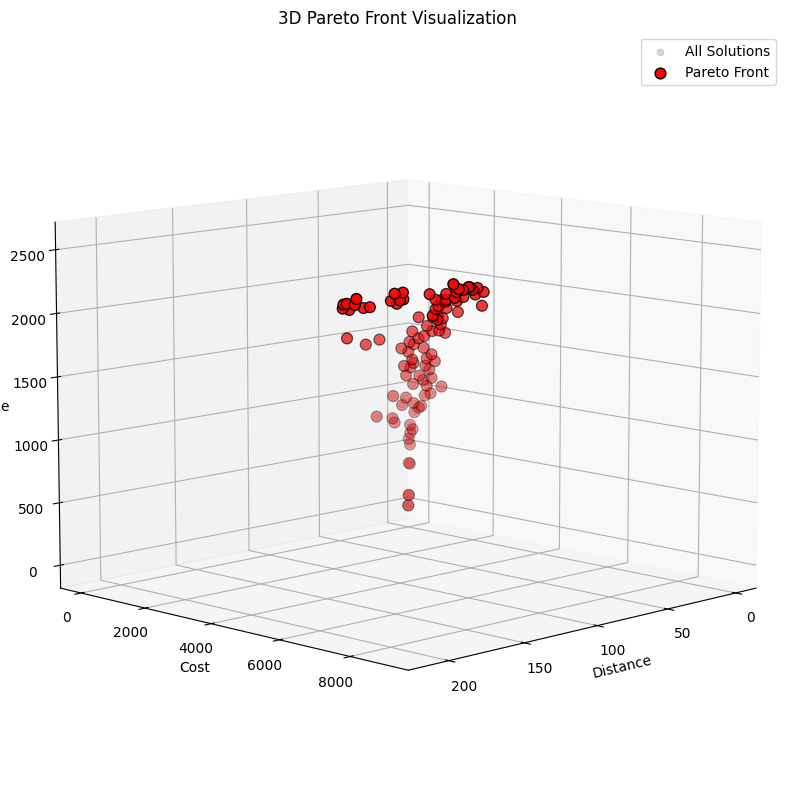

---------------
Best Route (order of locations): [  87    0  105  909   90  422   30  399  105 1348  105  904   15  927
   90  161   60 1263   75  956   75  820   15  962  105  684   75  483
  105  837   45  224   90  818   45  928   30 1140   45  829  105  496
   60  840   15  231  105  753  105  657   45 1006   45 1207   45  992
   60 1326   45 1236   30 1301   60  926   45  383   90  494   15  308
   15 1321   30  330   90 1014   30  268   75  667   45  412  105  733
   30  370   75 1042   30  334   75  623   90 1008   75  693   75  531
  105 1267   45  492   15  182  105  317   30  286   60  177   15 1222
   90  498   45  306   90  404  105  689   30  990   75 1216  105 1229
   30  535  105  700   75  800   45 1130   90 1314   45  773   30  384
   90  538  105  255   15  149   90  641  105  420   90  967  105  363
   60  919  105 1220   30  787   60  536   90  266  105  615   15  573
   30  779   30  765   30  941  105  724   45    0  105    0    0    0
    0    0    0    0    0   

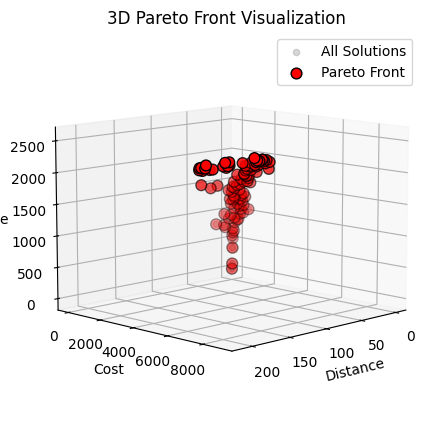

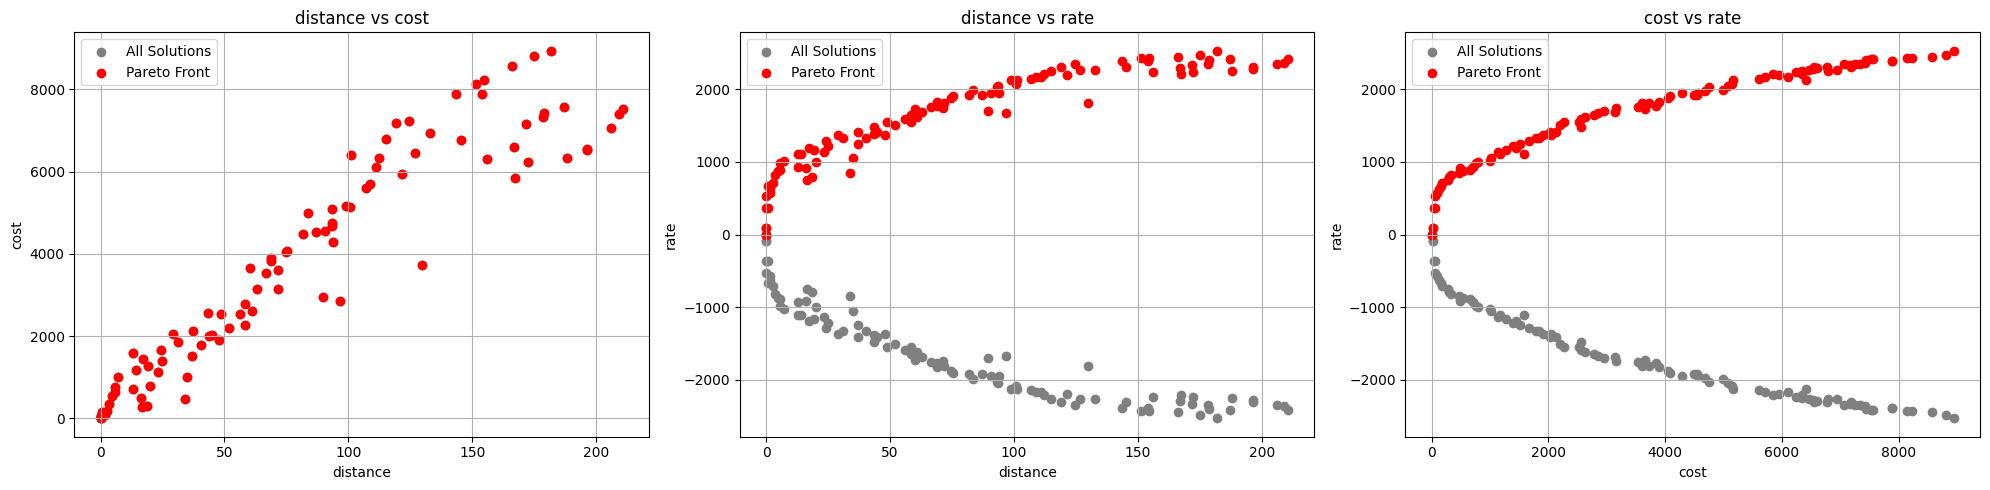

In [9]:
import random
import numpy as np
import folium
import matplotlib.pyplot as plt
import math
import ast

from os import replace
from pymoo.core.crossover import Crossover
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
from pymoo.core.crossover import Crossover
from pymoo.operators.selection.rnd  import RandomSelection
from pymoo.core.sampling import Sampling
from geopy.distance import geodesic
from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
from pymoo.core.callback import Callback
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.core.selection import Selection
from pymoo.visualization.scatter import Scatter
from pymoo.core.mutation import Mutation
from mpl_toolkits import mplot3d
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from mpl_toolkits.mplot3d import Axes3D
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.util.dominator import Dominator
from mpl_toolkits.mplot3d import Axes3D

def repairSolution(solution, n_var):
   solution = [int(row) for row in solution]

   sample = np.zeros(n_var)


   if(solution[0] != 0):

        length = solution[0] * GeneticAlgorithmConfig.timePlaceMappingSize
        head, interior, tail = getSliceRoute(solution)
        uniqueList = []

        for i in range(0, len(interior),GeneticAlgorithmConfig.timePlaceMappingSize):

          if(interior[i] not in uniqueList):
            for j in range(i, i+GeneticAlgorithmConfig.timePlaceMappingSize, 1):
              uniqueList.append(interior[j])
        lengthSolution = int((len(uniqueList) // GeneticAlgorithmConfig.timePlaceMappingSize))

        uniqueList = [lengthSolution] + head + uniqueList + tail
        return uniqueList

   else:
      return solution


def isValidSolution(solution):
   solution = [int(row) for row in solution]
   return True



def createSolution(n_var):
    hotel = locations[locations["type"] == "hotel"].sample(n=1)
    hotelId = hotel["Id"].values[0]

    sample = [-1 for _ in range(n_var)]
    rand = random.randint(0, 20)
    time = np.random.randint(1, 8) * 15
    currentLocationSize = rand
    start = GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * GeneticAlgorithmConfig.timePlaceMappingSize)
    end = (start + (rand * GeneticAlgorithmConfig.timePlaceMappingSize))
    sample[0] = currentLocationSize
    sample[1] = hotelId
    sample[2] = time
    sample[end] = hotelId
    sample[end+1] = time
    for i in range(start, end, GeneticAlgorithmConfig.timePlaceMappingSize):
      location = locations[locations["type"] != "hotel"].sample(n=1)
      sample[i] = location["Id"].values[0]
      time = np.random.randint(1, 8) * 15
      sample[i+1] = time


    return sample

n_obj = 3
best_per_generation = []  # لیستی برای هر تابع هدف



class CustomeCallback(Callback):
    def __init__(self, n_obj):
        super().__init__()
        self.n_obj = n_obj


    def notify(self, algorithm):

        combined_population = np.vstack([algorithm.pop.get("X"), algorithm.off.get("X")])

        # اصلاح جمعیت جدید
        new_population = np.zeros_like(combined_population)  # جمعیت جدید اصلاح‌شده

        for i in range(len(combined_population)):
            # اصلاح هر فرد از جمعیت
            individual = combined_population[i]

            # اصلاح فرد با استفاده از روش‌های مورد نظر (مثلاً ایجاد یک راه‌حل معتبر)
            # فرض کنید تابع اصلاحی createValidSolution این کار را انجام می‌دهد
            individual = repairSolution(individual, algorithm.problem.n_var)
            sample  = np.zeros(algorithm.problem.n_var)
            for j in range(len(individual)):
                sample[j] = individual[j]
            # اصلاح فرد در جمعیت جدید
            new_population[i] = sample
        F = np.zeros((new_population.shape[0], algorithm.problem.n_obj))
        algorithm.problem._evaluate(new_population, out={"F": F})


        if new_population.shape[0] == algorithm.pop.size:
            algorithm.pop.set("X", new_population)
        else:
            # اگر تعداد تغییر کرده، تعداد جمعیت را مطابق با نیاز تنظیم کنید
            algorithm.pop.set("X", new_population[:algorithm.pop.size])


        if algorithm.pop is not None:
            F = algorithm.pop.get("F")  # مقادیر تابع هدف
            X = algorithm.pop.get("X")


            pareto_indices = NonDominatedSorting().do(F, only_non_dominated_front=True)
            pareto_front = F[pareto_indices]


            x = pareto_front[:, 0]
            y = pareto_front[:, 1]
            z = abs(pareto_front[:, 2])
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            # رسم نقاط
            ax.scatter(F[:, 0], F[:, 1], abs(F[:, 2]), label="All Solutions", color="gray", alpha=0.3)
            ax.scatter(pareto_front[:, 0], pareto_front[:, 1], abs(pareto_front[:, 2]), label="Pareto Front", color="red", edgecolor="black", s=60)
            # ax.scatter(x, y, z, c=z, cmap='viridis', s=10)  # s اندازه نقاط است
            # تنظیم زاویه دید
            ax.view_init(elev=10, azim=45)  # elev زاویه ارتفاع و azim زاویه افقی است
            # نمایش نمودار
            ax.set_xlabel("Distance")
            ax.set_ylabel("Cost")
            ax.set_zlabel("Rae")
            ax.set_title("3D Pareto Front Visualization")
            ax.legend()
            plt.show()




class CustomMutation(Mutation):
    def __init__(self, mutation_rate=0.1):
        super().__init__()
        self.mutation_rate = mutation_rate  # احتمال جهش

    def _do(self, problem, X, **kwargs):
        X_mutated = X.copy()
        n, d = X.shape  # تعداد کروموزوم‌ها و متغیرها

        # for i in range(n):
        #     if np.random.rand() < self.mutation_rate:
        #         if X_mutated[i, 0] > 2:
        #           j = np.random.randint(2, X_mutated[i, 0])  # انتخاب یک ژن تصادفی برای تغییر
        #           X_mutated[i, j] = getLocation()
        return X_mutated



class CustomSampling(Sampling):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var  # تعداد متغیرها
        xl = problem.xl        # حد پایین متغیرها
        xu = problem.xu        # حد بالا متغیرها
        samples = np.zeros([n_samples, n_var], dtype=int)

        for row in range(len(samples)):
            samples[row] = createSolution(n_var)

        return samples


def getObjective(routes, prefernces):
    total_distance = []
    total_cost = []
    total_rate = []



    for route in routes:

        countHotel = 0
        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0
        averageRate = 0
        startRoute = GeneticAlgorithmConfig.totalLocationSize
        endRoute  = route[0] * GeneticAlgorithmConfig.timePlaceMappingSize


        # calculate distance
        for i in range(startRoute, route[0], GeneticAlgorithmConfig.timePlaceMappingSize):


            start, end = int(route[i]), int(route[i + GeneticAlgorithmConfig.timePlaceMappingSize])

            start = locations[locations["Id"] == start]
            end = locations[locations["Id"] == end]

            start_lat, start_lon = start["Latitude"].values[0], start["Longitude"].values[0]
            end_lat, end_lon = end["Latitude"].values[0], end["Longitude"].values[0]

            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)



        # caculate rate
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

          node = locations[locations["Id"] == route[i]]
          if(len(node["tag"]) > 0):
            tags = node["tag"].values[0]
            tags = tags.replace("[" ,"")
            tags = tags.replace("'" ,"")
            tags = tags.replace(']', "")
            tags = tags.replace(' ', "")
            tags = tags.split(',')
            for tag in tags:
              if(tag in prefernces):
                rate -=  node["Stars"].values[0] * prefernces[tag]
            averageRate = rate / len(tags)

            averageRate *= route[i+1]


        # caculate cost
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

            node = locations[locations["Id"] == route[i]]
            cost += node["Price"].values[0]

        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(averageRate)

    return (total_distance, total_cost, total_rate)


# مدل و الگوریتم NSGA-II
class HotelRouteProblem(Problem):
    def __init__(self, n_var, prefernces=None):
      self.prefernces = prefernces
      super().__init__(n_var=n_var,
                         n_obj=3,
                         n_constr=0,
                         xl=0,
                         xu=len(locations) - 1)

    def _evaluate(self, x, out, *args, **kwargs):
        total_distance, total_cost, total_rate = getObjective(x, self.prefernces)
        out["F"] = np.column_stack([total_distance, total_cost, total_rate])

class CustomeCrossover(Crossover):
    def __init__(self):


        super().__init__(2,2)

    def _do(self, problem, X, **kwargs):

        _, n_matings, n_var = X.shape
        Y = np.full_like(X, None, dtype=object)

        for k in range(n_matings):
            while True:
              # انتخاب والدین
              parent1 = [int(item) for item in X[0, k]]
              parent2 = [int(item) for item in X[1, k]]

              head1, interior1, tail1 = getSliceRoute(parent1)
              head2, interior2, tail2 = getSliceRoute(parent2)

              point1 = 0
              point2 = 0
              if((len(interior1) // GeneticAlgorithmConfig.timePlaceMappingSize) > 0):
                  point1  = np.random.randint(0, len(interior1) / GeneticAlgorithmConfig.timePlaceMappingSize)

              if((len(interior2) // GeneticAlgorithmConfig.timePlaceMappingSize) > 0):
                point2 = np.random.randint(0, len(interior2) / GeneticAlgorithmConfig.timePlaceMappingSize)

              child1 = interior1[:point1*GeneticAlgorithmConfig.timePlaceMappingSize] + interior2[point2*GeneticAlgorithmConfig.timePlaceMappingSize:]
              child2 = interior2[:point2*GeneticAlgorithmConfig.timePlaceMappingSize] + interior1[point1*GeneticAlgorithmConfig.timePlaceMappingSize:]

              lenChild1 = int(len(child1) // GeneticAlgorithmConfig.timePlaceMappingSize)
              lenChild2 = int(len(child2) // GeneticAlgorithmConfig.timePlaceMappingSize)



              child1 = [lenChild1] + head1 + child1 + tail1
              child2 = [lenChild2] + head2 + child2 + tail2

              childSample1  = np.zeros(n_var)
              childSample2  = np.zeros(n_var)

              child1 = repairSolution(child1, n_var)
              child2 = repairSolution(child2, n_var)




              for i in range(len(child1)):
                childSample1[i] = child1[i]
              for i in range(len(child2)):
                  childSample2[i] = child2[i]
              break

            # ذخیره فرزندان
            Y[0, k] = childSample1
            Y[1, k] = childSample2

        return Y


n_var = GeneticAlgorithmConfig.n_var


def tournament_comp_func(pop, P, **kwargs):
    F = pop.get("F")[P]
    dom = Dominator()
    for i in range(len(P)):
        if all(dom.compare(F[i], F[j]) <= 0 for j in range(len(P)) if i != j):
            return i
    return 0

# استفاده از انتخاب تورنمنت


algorithm = NSGA2(pop_size=100,
                  sampling=CustomSampling(),
                  crossover=CustomeCrossover(),
                  tournament=TournamentSelection(func_comp=tournament_comp_func),
                  callback=CustomeCallback(n_obj=3),
                  mutation=CustomMutation(mutation_rate=0.3),
                  )

userPreference = {"historical": 5,
                  "Recreational": 0.1,
                  "Natural": 0.1,
                  "Adventure": 0.1,
                  "Religious": 0.1,
                  "Resort": 1,
                  "Artistic": 0.1,
                  "Photography": 0.1,
                  "Cultural": 0.1}



problem = HotelRouteProblem(n_var=n_var, prefernces=userPreference)
res = minimize(problem,
               algorithm,
               termination=('n_gen', 50),
               verbose=False,
               eliminate_duplicates=True)



best_index = np.argmin(res.F[:, 2])
best_route = res.X[best_index].astype(int)
best_distance = res.F[best_index, 0]
best_cost = res.F[best_index, 1]
best_rate = res.F[best_index, 2]



print('---------------')
print("Best Route (order of locations):", best_route)
print("Best Distance:", best_distance)
print("Best Cost:", best_cost)
print("Best rate:", abs(best_rate))




pareto_indices = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
pareto_front = res.F[pareto_indices]


x = pareto_front[:, 0]
y = pareto_front[:, 1]
z = abs(pareto_front[:, 2])
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111, projection='3d')
# رسم نقاط
ax.scatter(res.F[:, 0], res.F[:, 1], abs(res.F[:, 2]), label="All Solutions", color="gray", alpha=0.3)
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], abs(pareto_front[:, 2]), label="Pareto Front", color="red", edgecolor="black", s=60)
# ax.scatter(x, y, z, c=z, cmap='viridis', s=10)  # s اندازه نقاط است
# تنظیم زاویه دید
ax.view_init(elev=10, azim=45)  # elev زاویه ارتفاع و azim زاویه افقی است
# نمایش نمودار
ax.set_xlabel("Distance")
ax.set_ylabel("Cost")
ax.set_zlabel("Rae")
ax.set_title("3D Pareto Front Visualization")
ax.legend()
plt.show()


plt.figure(figsize=(20, 5))

# هدف 1 مقابل هدف 2
plt.subplot(1, 3, 1)
# plt.scatter(res.F[:, 0], res.F[:, 1], c="gray", label="All Solutions")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("cost")
plt.title("distance vs cost")
plt.legend()
plt.grid()

# هدف 1 مقابل هدف 3
plt.subplot(1, 3, 2)

plt.scatter(pareto_front[:, 0], abs(pareto_front[:, 2]), c="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("rate")
plt.title("distance vs rate")
plt.legend()
plt.grid()

# هدف 2 مقابل هدف 3
plt.subplot(1, 3, 3)
plt.scatter(pareto_front[:, 1], abs(pareto_front[:, 2]), c="red", label="Pareto Front")
plt.xlabel("cost")
plt.ylabel("rate")
plt.title("cost vs rate")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



# routePrefence = {}

# for i in range(1, best_route[0]+1):
#   location = locations[locations["Id"] == best_route[i]]

#   tags = location["tag"]
#   for index, values in tags.items():
#     value = values
#     value = value.replace("[" ,"")
#     value = value.replace("'" ,"")
#     value = value.replace(']', "")
#     value = value.replace(' ', "")
#     value = value.split(',')
#     for item in value:
#       if(item in routePrefence):
#           routePrefence[item] += 1
#       else:
#           routePrefence[item] = 1

# labels = list(routePrefence.keys())
# values = list(routePrefence.values())

# # رسم نمودار میله‌ای
# plt.figure(figsize=(8, 10))
# plt.bar(labels, values)

# # تنظیمات نمودار
# plt.xlabel("Preferences")
# plt.ylabel("Scores")
# plt.title("User Preferences for Tourism")
# plt.ylim(0, 15)  # تنظیم محدوده امتیازات
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # نمایش نمودار
# plt.show()

           Item  Score  Rank
0     Item_1219    5.0     1
1      Item_672    5.0     2
2     Item_1125    5.0     3
3     Item_1003    5.0     4
4      Item_314    5.0     5
...         ...    ...   ...
1595  Item_1218    1.0  1596
1596  Item_1495    1.0  1597
1597  Item_1141    1.0  1598
1598   Item_424    1.0  1599
1599   Item_414    1.0  1600

[1600 rows x 3 columns]


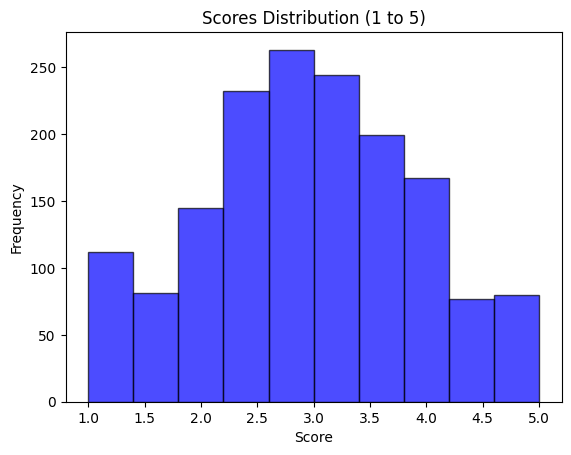

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# پارامترهای توزیع نرمال
mean_score = 3  # میانگین امتیاز (در وسط بازه 1 تا 5)
std_dev = 1     # انحراف معیار امتیاز

# تعداد آیتم‌ها
num_items = 1600

# تولید امتیازات خام با توزیع نرمال
raw_scores = np.random.normal(mean_score, std_dev, num_items)

# محدود کردن امتیازات به بازه 1 تا 5
scores = np.clip(raw_scores, 1, 5)

# ایجاد دیتافریم
data = pd.DataFrame({'Item': [f'Item_{i+1}' for i in range(num_items)], 'Score': scores})

# مرتب‌سازی بر اساس امتیاز و اختصاص رتبه
data = data.sort_values(by='Score', ascending=False).reset_index(drop=True)
data['Rank'] = data.index + 1

# نمایش داده‌ها
print(data)

# رسم هیستوگرام امتیازات
plt.hist(scores, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Scores Distribution (1 to 5)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import folium

# ایجاد یک نقشه در مرکز اولین مکان
map_center = [locations["Longitude"].mean(), locations["Latitude"].mean()]
mymap = folium.Map(location=map_center, zoom_start=13)

for key in range(1, best_route[0] * 3, 3):

    location = locations[locations["Id"] == best_route[key]]
    color = 'blue'

    folium.Marker(
        location=[location["Longitude"].values[0], location["Latitude"].values[0]],
        popup= location["tag"].values[0],
        tooltip=f"{location['name'].values[0]}",
        icon=folium.Icon(color=color)
    ).add_to(mymap)


mymap




الگوریتم فازی - برای هر هتل سه مقدار بدبینانه،خوش بینانه و متوسط رو در نظر می گیریم

In [ ]:
import requests

# API Key خود را اینجا وارد کنید
API_KEY = '3k_wLMNf6CwujHWVLSLnoZFLnuDLAkzBrLxfZU9GT5cG2tkgngTk3YcAD80AUOTE665dznOmk1LXWbVHFvtBehmk-ao0Dnzo7urxabgbhvXWcDzWSRNWfvoXm-cDZ3Yx'

# URL پایه برای درخواست‌ها
url = 'https://api.yelp.com/v3/businesses/SoSQhqqOaS10aUuxDr1YtA'

# سربرگ‌ها (Headers) با کلید API
headers = {
    'Authorization': f'Bearer {API_KEY}',
}

# پارامترهای جستجو (می‌توانید موقعیت جغرافیایی، نوع کسب‌وکار و غیره را مشخص کنید)
params = {
    # 'term': 'hotels',   # نوع کسب‌وکار
    'location': 'New York',  # مکان
    'limit': 5               # تعداد نتایج
}

# ارسال درخواست به Yelp API
response = requests.get(url, headers=headers, params=params)

# بررسی وضعیت درخواست و چاپ نتایج
if response.status_code == 200:
    data = response.json()
    businesses = data.get('businesses')
    print(businesses)
    # for business in businesses:
    #     print(f"Name: {business['name']}, Rating: {business['rating']}, Address: {', '.join(business['location']['display_address'])}")
else:
    print(f"Error: {response.status_code}, {response.text}")


In [ ]:
filtered_df = locations[locations['tag'].apply(lambda x: 'restaurant')]
filtered_df

Unnamed: 0                     name                     name:en  \
603         603         خانه سنتی پرهامی  Parhami Traditional Hostel   
657         657                عمارت فیل           House of Elephant   
660         660             هتل سنتی آنا       Ana Traditional Hotel   
674         674  اقامتگاه سنتی ایران مهر     Iranmehr Boutique Hotel   
694         694        هتل عمارت قاجاریه             Ghajarieh Hotel   
706         706            خانه سنتی ملک     Malek Traditional House   
713         713             سرای آناهیتا               Anahita House   

                          tag        type   Latitude  Longitude   Id  Stars  \
603  ['restaurant', 'Resort']  restaurant  52.548575  29.610513  603      5   
657  ['restaurant', 'Resort']  restaurant  52.550227  29.611304  657      4   
660  ['restaurant', 'Resort']  restaurant  52.549947  29.608176  660      5   
674  ['restaurant', 'Resort']  restaurant  52.546682  29.614183  674      4   
694  ['restaurant', 'Resort']  restaurant  52.545907  29.608112  694      1   
706  ['restaurant', 'Resort']  restaurant  52.548940  29.610559  706      1   
713  ['restaurant', 'Resort']  restaurant  52.547054  29.614590  713      2   

     Price  
603     35  
657     80  
660     44  
674    153  
694    168  
706     58  
713     73